# Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import csv
from sklearn import svm
import sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
import requests
import json
import scipy

In [169]:
users = pd.read_csv('users_one_mission.csv')
labels = pd.read_csv('ml-label-correctness-one-mission.csv')
grouped_labels = labels.groupby('user_id')
logins = pd.read_csv('seattle-login-counts.csv')
sessions = pd.read_csv('seattle-session-counts.csv')

In [170]:
# Keep the user that meet a certain criteria to analyze
to_remove = []
for index, current in enumerate(users['labels_validated']):
    if current < 16:
        to_remove.append(index)
users.drop(users.index[to_remove], inplace=True)
users = users.reset_index(drop = True)
display(users)
display(len(users))

,user_id,total_labels,labels_validated,correct_labels,false_labels,accuracy,missions_completed
0,05de1cc4-02b3-4eb7-9958-2a4a2d32b828,123,62,37,25,59.677419,7
1,07924321-e2a1-4ff2-b311-f9b0cf92f9b0,57,21,12,9,57.142857,7
2,0b736a27-87a7-47cb-9020-cfced7203e27,39,21,13,8,61.904762,5
3,0ce035b0-0367-45cb-aa83-1cb334b7c07a,55,39,35,4,89.743590,5
4,0d0fdbda-4abb-4bb4-84f4-bd0c76eb84e1,69,35,21,14,60.000000,5
5,0e1ae564-6d72-4670-98e4-71369cc5ab26,7194,1690,1321,369,78.165680,364
6,11665b4a-b749-4d86-aa22-246b3000883b,25,16,15,1,93.750000,5
7,1353d168-ab49-4474-ae8a-213eb2dafab5,714,213,120,93,56.338028,64
8,173f7190-7127-4651-8d4a-8a6e87c17afc,73,40,10,30,25.000000,5
9,19735043-3130-4bb5-aa56-ba1a505b9240,39,18,17,1,94.444444,3


177

In [77]:
# Users w/ accuracies below 65% and are not in neighorhoods without sidewalks
overall_bad_users = ['1353d168-ab49-4474-ae8a-213eb2dafab5', '35872a6c-d171-40d9-8e66-9242b835ea71',
                     '6809bd6e-605f-4861-bc49-32e52c88c675', '939b6faa-0b57-4160-bcc2-d11fd2b69d9f',
                      'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5']

In [78]:
# hgih school student onr Project Sidewalk as community service
hs_users = ['d2b04e27-13ce-4aff-a06a-7c7147c96696']

In [5]:
# all the tags belonging to each label type
curb_ramp_tags = ['narrow', 'points into traffic', 'missing friction strip', 'steep', 'not enough landing space']
obstacle_tags = ['fire hydrant', 'pole', 'tree', 'vegetation', 'trash/recycling can', 'parked car', 'parked bike']
missing_curb_ramp_tags = ['alternate route present', 'no alternate route', 'unclear if needed']
surface_problem_tags = ['bumpy', 'uneven', 'cracks', 'grass', 'narrow sidewalk']
no_sidewalk_tags = ['ends abruptly', 'street has a sidewalk', 'street has no sidewalks']
other_tags = ['missing crosswalk', 'no bus stop access']

In [21]:
# parses through each user's csv and figures out how many unique panos and missions seen
user_panos = {}
# user_missions = {}
for current_user in users['worker1']:
    df_current = pd.read_csv('{0}_dc.csv'.format(current_user))
    user_panos[current_user] = df_current['gsv_panorama_id'].nunique()
#     user_missions[current_user] = df_current['mission_id'].nunique()
df_current = None

In [15]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}_new.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}_new.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [16]:
# Parses through the csv and creates new csv for every user & action
with open('dc-all-interactions.csv', newline = '') as data:
    reader = csv.reader(data)
    header = []
#     users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
#             users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [ ]:
# Takes all label data from a csv and creates csv of each user's calculated label data
user_labels = {}
labels_grouped = labels.groupby('user_id')
for current_id, current_group in labels_grouped:
    total = len(current_group)
    accuracy = 0
    correct = sum(current_group['correct'] == 't')
    false = sum(current_group['correct'] == 'f')
    validated = correct + false
    if validated != 0:
        accuracy = float(correct) / float(validated) * 100
    missions_completed = user_missions[current_id]
    user_labels[current_id] = current_id, total, validated, correct, false,  accuracy, missions_completed
header = ['user_id', 'total_labels', 'labels_validated', 'correct_labels', 'false_labels', 'accuracy', 'missions_completed']
with open('users_one_mission.csv', 'w', newline = '') as new_user:
    writer = csv.writer(new_user)
    writer.writerow(header)
for user in user_labels.values():
    with open('users_one_mission.csv', 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(user)

In [ ]:
# Created a csv file of all of the No Sidewalk labels
with open('LabelingCanvas_FinishLabeling.csv', newline = '') as data:
    reader = csv.reader(data)
    for index, row in enumerate(reader):
        if row[1] == 'user_id':
            header = row
        else:
            if index == 0:
                with open('All_Nosidewalk_labels.csv', 'w', newline = '') as new_user:
                        writer = csv.writer(new_user)
                        writer.writerow(header)
            else:
                with open('All_Nosidewalk_labels.csv', 'a', newline = '') as edit_user:
                    editor = csv.writer(edit_user)
                    if 'NoSidewalk' in row[11]:
                        editor.writerow(row)

In [22]:
# Counting the number of tags placed of a certain type
def tag_counter(tag_type_heading, tag_type_kinds, tag_type):
    user_information = {}
    df_information = pd.read_csv('ContextMenu_TagAdded.csv')
    df_grouped = df_information.groupby(['user_id'])
    for current, group in df_grouped:
        users_index = (users['user_id'] == current).idxmax()
        tags_count = 0
        for current_index, current_type in enumerate(group['note']):
            beginning_length = current_type.find('tagName:') + 8 
            ending_length = 13 + len(str(group['audit_task_id'].iloc[current_index]))
            if current_type[beginning_length:-ending_length] in tag_type_kinds:
                tags_count += 1
        current_accuracy = users['accuracy'][users_index]
        if tag_type != None:
            current_accuracy = label_type_accuracy[current, tag_type] * 100
        user_information[current] = tags_count, current_accuracy, users['accuracy'][users_index]
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['accuracy'][index], users['accuracy'][users_index]
    tag_scatter_plot(tag_type_heading, user_information)

In [75]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts a string for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission.
def counting_graph (info_type, graph_type, multi_plot, action):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        users_index = (users['worker1'] == current_id).idxmax()
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users['f.measure'][users_index], current_id
    for index, current_user in enumerate(users['worker1']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['f.measure'][index], current_user
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, multi_plot)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [114]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
def scatter_plot(info_type, user_information, multi_plot):
    if multi_plot:
        user_information_pano = []
        user_information_mission = []
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            if entry in user_panos:
                user_info = user_information.get(entry)
                info = float(user_info[0]) / float(user_panos[entry])
                accuracy = user_info[1]
                current_user_id = user_info[2]
                user_information_pano.append([info,accuracy])
                if entry in overall_bad_users: 
    #             if accuracy < 65:
                    plt.plot(info, accuracy, '.', color = 'red')
                elif entry in hs_users:
                    plt.plot(info, accuracy, '.', color = 'green')
                elif accuracy < 0.65:
                    plt.plot(info, accuracy, '.', color = 'black')
                else:
                    plt.plot(info, accuracy, '.', color = 'blue')
        temp = np.array(user_information_pano)
        z = np.polyfit(temp[:,0],temp[:,1],1)
        w = np.poly1d(z)
        pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
        plt.plot(temp[:,0],w(temp[:,0]))
        plt.legend(['R =' + str(f'{pears[0]:.2f}')])
#         plt.subplot(132)
#         plt.ylabel('User Accuracy')
#         plt.xlabel(info_type + ' per Mission Started')
#         for entry in user_information.keys():
#             if entry in user_missions:
#                 user_info = user_information.get(entry)
#                 info = float(user_info[0]) / float(user_missions[entry])
#                 accuracy = user_info[1]
#                 user_information_mission.append([info,accuracy])
#                 if entry in overall_bad_users: 
#     #             if accuracy < 65:
#                     plt.plot(info, accuracy, '.', color = 'red')
#                 elif entry in hs_users:
#                     plt.plot(info, accuracy, '.', color = 'green')
#                 elif accuracy < 65:
#                     plt.plot(info, accuracy, '.', color = 'black')
#                 else:
#                     plt.plot(info, accuracy, '.', color = 'blue')
#         temp = np.array(user_information_mission)
#         z = np.polyfit(temp[:,0],temp[:,1],1)
#         w = np.poly1d(z)
#         pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
#         plt.plot(temp[:,0],w(temp[:,0]))
#         plt.legend(['R =' + str(f'{pears[0]:.2f}')])
#         plt.subplot(131)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        if entry in overall_bad_users:
#         if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif entry in hs_users:
                    plt.plot(info, accuracy, '.', color = 'green')
        elif accuracy < 0.65:
                plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [25]:
# Creates a scatter plot based off of the accuracy of a specific tag type but colors by
# overall accuracy
def tag_scatter_plot(info_type, user_information):
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        total_accuracy = user_info[2]
        if entry in overall_bad_users:
#         if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif total_accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [26]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information)
    plt.xlabel(info_type)
    plt.ylabel('Count')

In [284]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown_old')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U36') dtype('<U36') dtype('<U36')

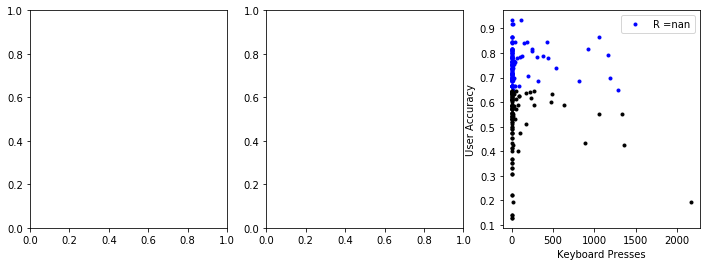

In [115]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown_dc')

In [ ]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown_old')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U36') dtype('<U36') dtype('<U36')

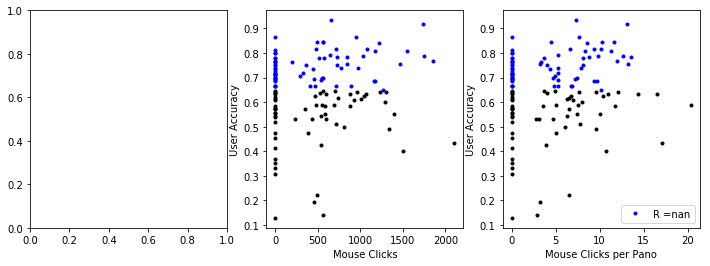

In [86]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown_dc')

In [ ]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete_old')

In [ ]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete')

In [ ]:
# Counts the number of zooms
counting_graph('Zooms', 'scatter_plot', True, 'Click_ZoomIn')

In [ ]:
# Counts the number of Labels Deleted
counting_graph('Label deleted', 'scatter_plot', True, 'RemoveLabel')

In [229]:
# Counts the total number of Tags Placed
counting_graph('Tag Added', 'scatter_plot', True, 'ContextMenu_TagAdded')

In [230]:
# number of curb ramp label tags compared to curb ramp accuracy
tag_counter('Curb Ramp Tags', curb_ramp_tags, 'CurbRamp')

In [231]:
# Number of missing curb ramp label tags compared to missing curb ramp accuracy
tag_counter('MissingCurb Ramp Tags', missing_curb_ramp_tags, 'NoCurbRamp')

In [232]:
# number of obstacle label tags compared to obstacle accuracy
tag_counter('Obstacle Tags', obstacle_tags, 'Obstacle')

In [233]:
# number of surface problem label tags compared to surface problem accuracy
tag_counter('Surface Problem Tags', surface_problem_tags, 'SurfaceProblem')

In [234]:
# Number of no sidewalk label tags compared to user accuracy
tag_counter('No Sidewalk Tags', no_sidewalk_tags, None)

In [235]:
# Counts the number of Label Confirmation based off of closing the context window
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling')

In [236]:
# Counts the number of mouse movements
counting_graph('Mouse Movement', 'scatter_plot', True, 'LowLevelEvent_mousemove')

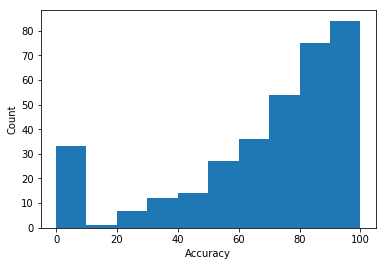

In [127]:
# Counts the number of users with different accuracies
histogram('Accuracy', users['accuracy'])

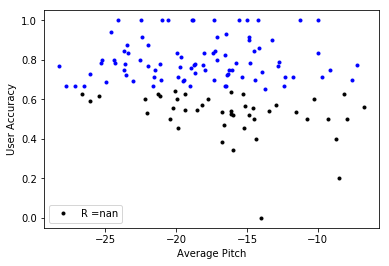

In [89]:
# Finds the average pitch, how far up or down the users is usally looking
user_information = {}
for index, current_id in enumerate(users['worker1']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    user_information[current_id] = df_current_user['pitch'].mean(), users['precision'][index]
scatter_plot('Average Pitch', user_information, False)

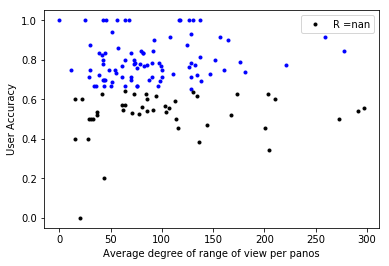

In [117]:
# Calculates the average range of how much a person looks looks side to side
# user_information = {}
for index, current_id in enumerate(users['worker1']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    current_heading = []
    for current, group in df_grouped:
        range = group['heading'].max() - group['heading'].min()
        current_heading.append(range)
        user_information[current_id] = (sum(current_heading) / float(len(current_heading))),users['precision'][index]
scatter_plot('Average degree of range of view per panos', user_information, False)

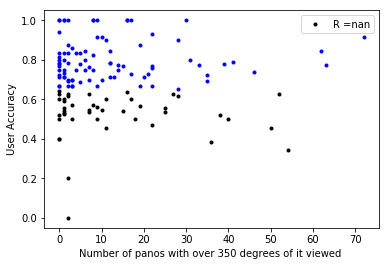

In [124]:
# Counts the number of times a user looks atleast 350 degrees of a pano
user_information = {}
for index, current_id in enumerate(users['worker1']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    full_heading_count = 0
    for current, group in df_grouped:
        range = group['heading'].max() - group['heading'].min()
        if range >= 350:
            full_heading_count += 1
    user_information[current_id] = full_heading_count, users['precision'][index]
scatter_plot('Number of panos with over 350 degrees of it viewed ', user_information, False)

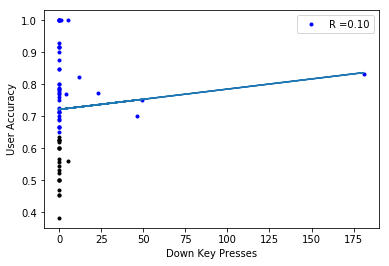

In [123]:
# Number of times the down key is pressed
user_information = {}
df_information = pd.read_csv('LowLevelEvent_keydown_dc.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    count = sum(group['note'].str.count('keyCode:40'))
    user_information[current] = count , users['precision'][users_index]
scatter_plot('Down Key Presses', user_information, False)

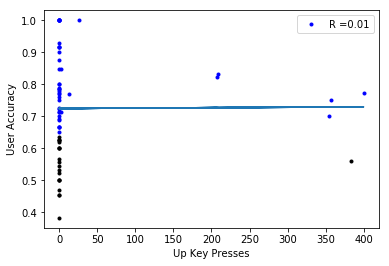

In [125]:
# Number of times the up key is pressed
user_information = {}
df_information = pd.read_csv('LowLevelEvent_keydown.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    count = sum(group['note'].str.count('keyCode:38'))
    user_information[current] = count , users['precision'][users_index]
scatter_plot('Up Key Presses', user_information, False)

In [129]:
# Counts the number of times a user goes back to a pano they've already been in during the
# same mission
user_information = {}
df_information = pd.read_csv('PanoId_Changed.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    mission_id = 0
    current_user_duplicates = 0
    total_user_duplicates = 0
    current_panos_seen = []
    for index, current_pano in enumerate(group['gsv_panorama_id']):
        current_mission = group['mission_id'].iloc[index]
        if current_mission != mission_id:
            total_user_duplicates += current_user_duplicates
            current_user_duplicates = 0
            current_panos_seen = [current_pano]
            mission_id = current_mission
        else:
            if current_pano in current_panos_seen:
                current_user_duplicates += 1
            else:
                current_panos_seen.append(current_pano)
    user_information[current] = total_user_duplicates, users['precision'][users_index]
scatter_plot('Panos revisited', user_information, False)

In [128]:
#  Calculates the average length of comments
user_information = {}
df_information = pd.read_csv('ContextMenu_TextBoxChange.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    comment_length_total = 0
    comment_count = 0
    for index, current_comment in enumerate(group['note']):
        audit_task_id = group['audit_task_id'].iloc[index]
        end_length = len(str(audit_task_id)) + 13
        current_comment = current_comment[11:-end_length]
        comment_count += 1
        comment_length_total += len(current_comment)
    user_information[current] = float(comment_length_total) / comment_count, users['precision'][users_index]
for index, current_user in enumerate(users['worker1']):
    if current_user not in user_information:
        user_information[current_user] = 0, users['precision'][index]
scatter_plot('Average Comment Length', user_information, False)

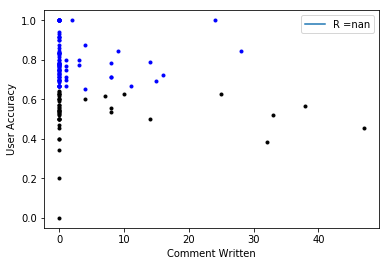

In [133]:
# Counts the number of Comments Written
user_information = {}
df_information = pd.read_csv('ContextMenu_TextBoxChange.csv')
df_grouped = df_information.groupby(['user_id'])
for index, current_id in enumerate(df_grouped.groups):
    users_index = (users['worker1'] == current_id).idxmax()
    user_information[current_id] = len(df_grouped.get_group(current_id)), users['precision'][users_index]
for index, current_user in enumerate(users['worker1']):
    if current_user not in user_information:
        user_information[current_user] = 0, users['precision'][index]
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])
scatter_plot('Comment Written', user_information, False)

In [184]:
# Creates a lists of each user's outputs (Quality 0 = Bad, 1 = Good, and accuracy)
# Also creates an list for features
# for the DC data, I don't have an 'accuracy' becasue that is based off of Seattel validations
# so their precision and recall is recorded
def create_groups():
    for index, entry in enumerate(users['user_id']):
        current_accuracy = users['accuracy'][index]
#         current_recall = users['recall'][index]
#         current_precision = users['precision'][index]
#         worker_type = users['worker.type'][index]
        if current_accuracy <= 65:
            quality = '0'
        else:
            quality = '1'
        all_output.append([quality, current_accuracy])
        all_data[entry] = [0]
        all_id.append(entry)

In [194]:
# Adds a feature into the features list of both the training and testing model
# Feature is the name of the user action that is recorded
def add_feature(feature, info_type, feature_title, multi):
    if feature_title not in all_feature_header:
        for index, entry in enumerate(users['user_id']):
            df_user = pd.read_csv('{0}_new.csv'.format(entry))
            if info_type == 'count':
                if multi == True:
                    by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
                    pano_mean = by_pano.mean()
                    pano_std = by_pano.std()
                    by_mission = df_user.groupby('mission_id').apply(lambda x: sum(x['action'] == feature))
                    mission_mean = by_mission.mean()
                    mission_std = by_mission.std()
                else:
                    info = action_count[feature] 
            elif info_type == 'pitch':
                info = df_user['pitch'].mean()     
            elif info_type == 'heading':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                current_heading = []
                for current, group in df_grouped:
                    current_heading.append(group['heading'].max() - group['heading'].min())
                info = (sum(current_heading) / float(len(current_heading))) 
            elif info_type == 'heading 350':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                full_heading_count = 0
                for current, group in df_grouped:
                    range = group['heading'].max() - group['heading'].min()
                    if range >= 350:
                        full_heading_count += 1
                info = full_heading_count / float(user_panos[entry])
            else:
                pano_mean = 0
                pano_std = 0
                mission_mean = 0
                mission_std = 0
                info = 0
            if multi:
                all_data[entry].append(mission_mean)
                all_data[entry].append(pano_mean)
                all_data[entry].append(mission_std)
                all_data[entry].append(pano_std)
            else:
                all_data[entry].append(info)
        if multi:
            all_feature_header.append(feature_title + ' per Mission')
            all_feature_header.append(feature_title + ' per Pano')
            all_feature_header.append(feature_title + ' Standard Deviation per Mission')
            all_feature_header.append(feature_title + ' Standard Deviation per Pano')
        else:
            all_feature_header.append(feature_title)

In [192]:
# Creates empty lists to hold all of the user data
all_data = {}
all_id = []
all_output = []
all_feature_header = ['test']
output_header = ['Quality', 'accuracy']
create_groups()

In [196]:
display(all_data)
display(all_id)
display(all_output)
display(all_feature_header)

{'05de1cc4-02b3-4eb7-9958-2a4a2d32b828': [0,
  2.4285714285714284,
  0.1118421052631579,
  2.935821455580639,
  0.6764666881688712],
 '07924321-e2a1-4ff2-b311-f9b0cf92f9b0': [0,
  1.0,
  0.06666666666666667,
  1.4142135623730951,
  0.3471495650477199],
 '0b736a27-87a7-47cb-9020-cfced7203e27': [0,
  0.2,
  0.012987012987012988,
  0.44721359549995804,
  0.113960576459638],
 '0ce035b0-0367-45cb-aa83-1cb334b7c07a': [0,
  2.0,
  0.12987012987012986,
  1.8708286933869707,
  0.3752420043907578],
 '0d0fdbda-4abb-4bb4-84f4-bd0c76eb84e1': [0,
  1.8,
  0.10588235294117647,
  2.489979919597747,
  0.5778352338019626],
 '0e1ae564-6d72-4670-98e4-71369cc5ab26': [0,
  1.4285714285714286,
  0.04212572909915749,
  1.5021956906327227,
  0.22268907789262407],
 '11665b4a-b749-4d86-aa22-246b3000883b': [0,
  0.4,
  0.03076923076923077,
  0.5477225575051662,
  0.17403580533459634],
 '1353d168-ab49-4474-ae8a-213eb2dafab5': [0,
  0.53125,
  0.015440508628519528,
  1.3448166217115798,
  0.14992808014848022],
 '17

['05de1cc4-02b3-4eb7-9958-2a4a2d32b828',
 '07924321-e2a1-4ff2-b311-f9b0cf92f9b0',
 '0b736a27-87a7-47cb-9020-cfced7203e27',
 '0ce035b0-0367-45cb-aa83-1cb334b7c07a',
 '0d0fdbda-4abb-4bb4-84f4-bd0c76eb84e1',
 '0e1ae564-6d72-4670-98e4-71369cc5ab26',
 '11665b4a-b749-4d86-aa22-246b3000883b',
 '1353d168-ab49-4474-ae8a-213eb2dafab5',
 '173f7190-7127-4651-8d4a-8a6e87c17afc',
 '19735043-3130-4bb5-aa56-ba1a505b9240',
 '19ce7bb2-1ef5-4904-9582-67a2b567cd29',
 '1b5e103c-fbdc-45a7-aef7-d84dc2e9068d',
 '1cc1153c-5a90-4e6b-8cbe-04b7fd18c9ef',
 '1e00ac1d-234a-43a5-90d6-a32cb5b06572',
 '1e5b6eec-b36c-4a39-9f1f-b4587ccc4a55',
 '20130617-b211-45e4-89e6-1f2288283334',
 '205a2c36-8335-4373-aced-dfb05ce71b6a',
 '21d46b18-4f62-445d-b138-74d3763982d9',
 '24f9888a-c271-4b8f-9a5c-d67931c384b1',
 '264bd783-8487-4f0e-949b-b4ac32000e07',
 '2721e2d3-b15c-42df-b777-19b9c33e8636',
 '27d41f66-91f3-49dc-ab14-b8732d733554',
 '28b9dee0-bafe-42e7-815d-bc308c4d6213',
 '2a783c12-395c-4cdc-b954-b5a225771360',
 '2b0da548-ba7c-

[['0', 59.67741935483871],
 ['0', 57.14285714285714],
 ['0', 61.904761904761905],
 ['1', 89.74358974358975],
 ['0', 60.0],
 ['1', 78.16568047337276],
 ['1', 93.75],
 ['0', 56.338028169014095],
 ['0', 25.0],
 ['1', 94.44444444444444],
 ['1', 68.08510638297872],
 ['1', 90.4761904761905],
 ['1', 93.75],
 ['0', 52.941176470588246],
 ['1', 90.625],
 ['1', 68.29268292682927],
 ['0', 62.06896551724138],
 ['1', 94.11764705882351],
 ['1', 89.47368421052632],
 ['1', 100.0],
 ['1', 84.21052631578947],
 ['1', 80.55555555555556],
 ['1', 80.95238095238095],
 ['1', 68.0],
 ['0', 57.14285714285714],
 ['1', 100.0],
 ['0', 46.153846153846146],
 ['1', 89.4637817497648],
 ['1', 73.68421052631578],
 ['1', 91.30434782608695],
 ['1', 65.38461538461539],
 ['1', 96.875],
 ['1', 71.17794486215539],
 ['1', 74.6268656716418],
 ['1', 72.72727272727273],
 ['1', 86.95652173913044],
 ['1', 88.4297520661157],
 ['0', 61.904761904761905],
 ['1', 78.125],
 ['0', 50.0],
 ['1', 76.66666666666667],
 ['1', 80.0],
 ['1', 82.3

['test']

In [195]:
# adds these features into the lists
add_feature( None, 'heading', 'Average Heading Range', False)
add_feature( None, 'heading 350', 'Panos w/ over 350 Degrees seen', False)
add_feature( None, 'pitch', 'Average Pitch', False)
add_feature( 'ContextMenu_TagAdded', 'count', 'Tags Added', True)
add_feature( 'LabelingCanvas_FinishLabeling', 'count', 'Labels Confirmed', True)
add_feature( 'RemoveLabel', 'count', 'Labels Removed', True)
add_feature( 'LowLevelEvent_keydown', 'count', 'Key Presses', True)
add_feature( 'LowLevelEvent_mousedown', 'count', 'Mouse Clicks', True)
add_feature( 'Click_ZoomIn', 'count', 'Zoom', True)
add_feature( 'ContextMenu_TextBoxChange', 'count', 'Comments Written', True)
add_feature( 'LowLevelEvent_mousemove', 'count', 'Mouse Movements', True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  if __name__ == '__main__':


mission_id  gsv_panorama_id       
392         2IXKA8Lo-Xz6bz3_dPS6wA    0
            2d6Kf5Gk3tVfyUD6h0xvKA    0
            4wawwbPlzvLVJRX7SLy8XQ    0
            9BxSq9LFyARXkV_D5yCYKg    0
            AqQn0Mm0QFkgrkXEy3Vw5Q    0
            BUP3CCAigkZYd_BFM6QWLg    0
            CqfIX7wj6Yq_huI1a7i9tQ    0
            F_pwhiAJTcDSxGDTQvMXsw    0
            Jx86XiqmkF4o84kB0ltp1w    0
            L80LTkZ1le-EL9u3XRDn1w    0
            PTHUzZqpLdS1nTixJMoDSw    0
            PwdT5dH4-XZvYJUlBZBIyg    0
            YuekAFS-BDpL47PIbmcZpA    0
            cIgtJq08EAvBBPDex_HGBg    0
            hMH7iUl27vaezayVfPtPZw    0
            stxXyCKAbd73DmkM2vsIHA    6
            zNgRlTNf5rHAn7Z6y1K-XQ    0
            zmaHWw1RBwEyWAinsqX3aQ    0
478         6Y_Smt9slfEzYDjbzfAkuA    0
            8o8dWxup0lCeitIOBzJklw    5
            90ScNSylleLDct8Yl1b07Q    0
            A0UgtueiEonbTErMLe1eZw    0
            IXuaxA5gSrmthmJNOq0-Dg    0
            IzDwe5gMte04acsaSCH_MA    0
     

mission_id
392    6
478    7
484    0
486    2
487    2
490    0
672    0
dtype: int64

mission_id  gsv_panorama_id       
6921        PTHUzZqpLdS1nTixJMoDSw    0
            YLQsuf1djjTyRTg9AmnGYA    0
            stxXyCKAbd73DmkM2vsIHA    1
6923        -oqhLTIPr94_5GTmxWt7dw    0
            01CL46WKXCgKz0xudb8Hcw    0
            1kefdJKlB7yfz3UbGsjvEw    0
            3opc9u2wb52zTdk54lKBsw    3
            CDR3JG8Xr4PeomICUITphQ    0
            K9fayqHHNs6wZm1eK24k7Q    0
            LFNp2_BkHgcJL9boCHnMFQ    0
            M-zPiel2NrV45Vos4ekn-A    0
            Mzt9ZUb1DBB4Dj-Tc4F5Aw    0
            NLd26S0WpyBm5MGlpluSjg    0
            PTHUzZqpLdS1nTixJMoDSw    0
            SArYmyBcnMXCv8KaYXPstA    0
            UhtvPuMClmlcxNkbLtCQeA    0
            WJkjdrZ4zrdAmWWeZk8szg    0
            X4NKajylZFqlmL8Y8gOLGQ    0
            _AjGJOyqmxFk3fNQqh6X1w    0
            cKmq4lpqGJRyzkvXn3nQlg    0
            cyMxyYC3FUDJECchg50DSA    0
            kEAE74y_xmhViab9vVUgbA    0
            qwwXH1l1SlbGRZbN1MYJNA    0
            tBMP0b7sqZq1AFs55LdXuQ    0
     

mission_id
6921    1
6923    3
6929    0
6934    0
6935    0
6937    3
6942    0
dtype: int64

mission_id  gsv_panorama_id       
7665        Erkn2Z2VPAeL2FZoRICg4g    0
            PTHUzZqpLdS1nTixJMoDSw    0
            stxXyCKAbd73DmkM2vsIHA    1
7691        3idNAJvxpNth_xr1T6-u2A    0
            6qz0HMStddG9-duapJTBTg    0
            7dM1gQ-sYtOqlusvjYd-3w    0
            8m70rWoYkDwuynKUOtLzWg    0
            92a9zg4JFRm05fNdv_-alA    0
            Am5I-IBt7UChg-7bt0FzxA    0
            B4DwZdxH_eNJM5Ge8lujIg    0
            FpAHJYuNBllrAIdIS7KdCA    0
            NJSywiVReeUFQ43dufmIAQ    0
            PTHUzZqpLdS1nTixJMoDSw    0
            QEZBjEai8y00JSx9_zrJcA    0
            Qj7ovfRzwgnb0GlhbnKcRw    0
            U1k3bQt_inRVW4HfnLetIw    0
            VYw76uZRpq9fOGevQmC25A    0
            W3WRF1N0UQFILBidsGiLlw    0
            _6lQ3Vy9OE4Ah42naNbFaA    0
            _e2YGKN8r0zLFmqo4l675w    0
            cXSPGItt4KBCpVCvqN0KRQ    0
            d9DFC7sftXfoKVFZNjlndw    0
            eJBsHQvwTj3rXKtj1iCdLw    0
            fteVBhS4uQxjVryILNY_fw    0
     

mission_id
7665    1
7691    0
7716    0
7733    0
7766    0
dtype: int64

mission_id  gsv_panorama_id       
929         N05HHpACv4BVrilzb-caWg    0
            PTHUzZqpLdS1nTixJMoDSw    0
            sTW4rEHz1Z8OuM_1j_gkZw    0
            stxXyCKAbd73DmkM2vsIHA    1
944         3cVMk8nTH_hvkIvKz7EG_A    0
            9qhlqXRrV2TM7REsCty0JQ    0
            Cm28r7Ln-4F2BX2iEKyu5g    1
            D14LnMRuaiTBi6S_-erXaw    0
            EQhcxn1Caddj4W29RNrnWA    0
            HSxCZPW2UKANuIBVp6vMWA    0
            MxR4YWn7Ha8bjvNnZ1pAfg    0
            N7qK9CNnKYMP8dO-mGKcdg    0
            Pepi6ht3q3Jg2yiCH9oEGw    0
            SN-tQhbyOHDnIe4QORuZWQ    0
            V2_vUoKLXZSJFydk7COf1g    0
            b-GLsDRJ7P6C-zWXlLXB4w    0
            cwWMf-16hLR2luf0RVB7pg    0
            hdF31Mk5k1FBge95HSpXzw    0
            kV7tuY6seDqp5LoM9DKrFA    0
            kgXbz_GdAXNbOlbhhO3Rlg    0
            p9CeEfBMqDZFA_PYMNLkCw    0
            svrv8mV0z0fip6ts7mAshA    0
948         1aPF0YlF5cnutyweQiU3Uw    0
            AMy0YK5e6tKbSaD4_gU9Nw    0
     

mission_id
929    1
944    1
948    4
951    4
955    0
dtype: int64

mission_id  gsv_panorama_id       
361         0rWFRzZ1TjMXjTzIMIYKNw    0
            2u2bu486JRAt5O7MRS4lbA    0
            5kPvUJSzkW3FJNSFm4pcPw    0
            6uW4u-N4_mL3H58ZEqJn1Q    0
            Eer01CS_wRmeGbFzXVlzvg    0
            Ju3oog3a23CNDOLR41M5zg    0
            NrpffijsaqHXbY9SqwwwBQ    0
            PTHUzZqpLdS1nTixJMoDSw    0
            UbSnUoBxgkKAmAxIhakHiQ    0
            ZcVfwdhE0N4aBNPCC26X8A    0
            amaVMV_xANRQuuX80SdSPA    0
            kGqJgO_K7Ed6SzwsqWUGEw    0
            lPliNK5zjopEbB9o8VxqfQ    0
            rEcSM1sTqNqxF4ZAubwdPg    0
            stxXyCKAbd73DmkM2vsIHA    5
            wcs1zCZ9sIOQa3Qb96Eaaw    0
            xgMANtrttXolNeOXOTseUA    0
1143        -tcTHQKQH7wsUwf4ZbmC5w    0
            3s2RDE-PU-LsC4kDRCeYDg    1
            4irk3YZMSXCncaPlD4NUFg    0
            DjkLA8lbCIynPX6E5PFi6g    0
            HCK9Cb5w6WhZ_T6AbAtuUw    0
            J7SR2os1N2T86mMH6fdkuA    0
            KgTgNGcNiPhFyhc3kQ1J9Q    0
     

mission_id
361     5
1143    4
1145    0
1147    0
1153    0
dtype: int64

mission_id  gsv_panorama_id       
2651        EchxW133W7pXDCdJM1Uq8w    0
            PTHUzZqpLdS1nTixJMoDSw    0
            stxXyCKAbd73DmkM2vsIHA    1
2652        5--MY3_Ida_ztqT5rgE9RQ    0
            7dIGqW2HCM_yTee2_BBJ4A    0
            Au2txVwMPZmm9yMRA2EjIA    0
            HjLeD-X32OX6c5ft-u6m9A    0
            HxakhJX5lgvcCHFn6wlW6A    0
            L7SZej2SoaWbaqWE5bdB3Q    0
            LQ6rSsYYxEVvARtdpdklWg    0
            PI5YGOLCCqstcmH0wnI63Q    0
            PTHUzZqpLdS1nTixJMoDSw    0
            Rmu4JghY1gVXNcn4vdOS3A    0
            RzJkQ2ZRDZbpt9Iw3esBlg    0
            UcjtApzHKzMrN0aO4Imv1w    0
            Y7wvmgrA41wlKm1tVNm7DA    0
            YkSJBfROkqpR_ewGZs_loA    0
            ZIHpcBhfMcMPcq_1-2bh8g    0
            _enGqEtRxK3LUwbgoEuatA    0
            aRVw7ni8urGy9XglFAMDeA    0
            eZud872UBnemc6MoKv59Ng    0
            h5u7mEuSWuGmMlMm2DGMiA    0
            iZyH9OTg4Jf8cjiE2EbWhg    0
            jDkfnb3wRBo90AO7ymyptw    0
     

mission_id
2651    1
2652    0
2653    0
2655    0
2656    0
2657    0
2658    0
2659    0
2866    3
2867    2
2869    1
2871    2
2873    2
2875    3
2877    3
2878    1
2881    1
3436    2
3438    1
3440    3
3443    3
3444    0
3447    1
3449    1
3450    1
3453    0
3456    1
3458    0
3460    1
3463    1
       ..
7361    0
7364    1
7365    2
7367    0
7369    0
7371    0
7375    0
7377    0
7379    1
7382    0
7384    0
7386    1
7387    1
7389    0
7390    0
7392    0
7394    1
7395    0
7396    0
7398    1
7399    0
7401    0
7403    0
7404    1
7407    0
7409    0
7410    0
7412    0
7413    0
7415    0
Length: 364, dtype: int64

mission_id  gsv_panorama_id       
1397        Bq3sdVuMUgZaFZP7nGDmzA    0
            CMGXMXk6k60JqeO_F8Qcyg    0
            PTHUzZqpLdS1nTixJMoDSw    0
            RxsydvSlWXeH3xfOHMqo3g    0
            ZD3_GBq20YUD9pMJ-mks5Q    0
            qBqonTSzoskfRQBJtx9BXg    0
            sBONtc3HZhdxgBJ4OPS1Pw    0
            stxXyCKAbd73DmkM2vsIHA    1
            wU9qJ7vPH6jeJ6oCV-RBYA    0
1407        1e_StI4APE6fXKns5zT-Lg    0
            7aMyk1J9puR92Jqhbb7jFQ    0
            B99eI6fMMWwTzXTbbvFmzg    0
            CdTO45btrerNu3JSnxBEFQ    0
            DEqDIt0D2UET6OzXBRXP3Q    0
            DniyBGKZUQzFpC-N0MwOmA    0
            DttiwfaQMRKLr1zO_nzTQA    0
            GMgKk-Fk5Jl3J0PTVheyaQ    0
            HedsYz85nqS4HEF35JRCgQ    0
            a2vwnzgt8pdieuBCG5uj5A    0
            aByDf9MX5yBF8Ef3BKT2iQ    0
            cYSlsyhA9X_zoxt03CG43A    0
            dqEXVqWiErTTjWB8EX09IA    0
            kC5J-f5n-cAxiVvlHrrh3A    0
            pDP_Q4npiarNSR6F0jJp2w    0
     

mission_id
1397    1
1407    0
1409    1
1413    0
1415    0
dtype: int64

mission_id  gsv_panorama_id       
2482        Ki8vfZxqpqq0jGc2f_bNnA    0
            PTHUzZqpLdS1nTixJMoDSw    0
            PfQbgsn4TkbCcWHaljXOfQ    0
            stxXyCKAbd73DmkM2vsIHA    2
2483        4uSA1LmHC3Ql6fuRyrIFrw    0
            EEGzBat0DuJNg81dGaFSJQ    0
            EHO3xpudi6Lkauxg2w2gqg    0
            FHV8RgtL6-an1fQK9LDkqg    0
            FyRNIKUffmtivuug1fA74g    0
            G6tDKCeUDuQn1JLwNuurew    0
            MB0IX-2b3aTidikRvWnWmg    0
            PTHUzZqpLdS1nTixJMoDSw    0
            PwGUOjSuX-6AuJa_1j7ufA    2
            Trr-mYVkxHUmKs5Ghyne8A    0
            V7z9SKRHv00DbJOKtkZXcg    0
            ZJH14gUIa-STAOJPx_hLWQ    3
            ZhD73GlVsEH3Uszg5cbH6g    0
            axt9qLFdYu7ZiHV2v0u88Q    0
            c_dqG_qErlMDh614E2HuRA    1
            doq4aY6KmTVugH13oCGSeg    0
            e2jgVqxknVmEwXD4sZ0UCQ    0
            eXeH-xFAvV3d_z032wYQTQ    0
            kxXiwFwPKgYru6bPbCgH2A    0
            mn3vO7tkfzC5oquGB41Bdw    1
     

mission_id
2482    2
2483    7
2531    2
2540    6
2549    0
2551    2
2554    4
3364    1
3366    1
3368    0
3371    3
3374    0
3380    0
3662    0
3664    0
3665    0
3670    0
3671    0
3674    0
3676    0
3679    0
3681    0
3684    0
3686    2
4082    0
4083    0
4084    0
4085    0
4086    1
4087    0
       ..
4535    0
4537    0
4539    0
4542    0
4544    0
4546    0
4547    0
4549    0
4550    0
4552    0
4553    1
5039    1
5041    0
5043    0
5046    0
5048    1
5049    0
5054    0
5833    0
5835    0
5838    0
5840    0
5844    0
5847    0
5850    0
5851    0
5852    0
5854    0
5855    0
5858    0
Length: 64, dtype: int64

mission_id  gsv_panorama_id       
10292       Kb1UoMG2LPkeEMY9sCzbcA    0
            afterWalkTutorial         0
            tutorial                  1
10293       -bPCEclyWthSSrQ1n072Yg    0
            2DxAKVIxVGP95IAxca7lVA    0
            CJlK_aJdnBUIxjxpYmgrFg    0
            CZC4iIm0Cjpcd2MQ0AnSpA    0
            DwGO7QnVCoFAgAF33Vb0oA    0
            ElKlsmPuAEyNlkkNamP1-A    0
            F7OvaIty32X5o1QXPt1PBw    0
            Fx0QKXXBND5JOHhKsRyw4w    1
            Kb1UoMG2LPkeEMY9sCzbcA    2
            XANl_WxAp5a2cDily4MRWw    0
            a7fLgOxLDLL7n9l2NMrH3Q    0
            afterWalkTutorial         0
            f93yLqxS4pxEkBcfI-_qxA    0
            p-icxN0JxEIDZJJNq6S3rA    0
            p9oYNcELEuBO3dgvU5O31w    0
            t1GcSgfKxj1sqNWAs8zDRw    0
            u5KAK04MmeuaA0yUdCazdQ    0
            uzu1TAXRXrKl3Gh6-9qn8g    0
10294       -XgkiV9EOkNtLQ0kMyQNvw    0
            -gHaglQNo23I8JdWXlFhDA    0
            0L2UtWvIn-ApBuhF0GSFNg    0
     

mission_id
10292    1
10293    3
10294    0
10310    3
10312    0
dtype: int64

mission_id  gsv_panorama_id       
3378        PTHUzZqpLdS1nTixJMoDSw    0
            Tc4pMTwa6LWMCjO5-rT0AA    0
            sEmBOSlsmnEVx_-wAGLvCA    0
            stxXyCKAbd73DmkM2vsIHA    1
3382        6KLfdRWsXuVtud0nB7qVUA    0
            8edh-wPAs7kM8f6IISLFUQ    0
            A_l-4aEkFPAC3gaIlKkJkw    1
            D0Ji_lnjuKWu7b1i4bQ1wg    0
            MfNYjfXQGfHfpWQMx_ZIlg    1
            PTHUzZqpLdS1nTixJMoDSw    0
            _TDu9Llfeh-SVDCe7P25SA    2
            lF8J37THTkekWnPvJOaJcA    0
            sw6NTFnP4ds5MDwXdaA41Q    0
            zEy5erG4AOVTGdCWOsOWpg    0
3385        15OZjQD4EMVZVNJEgNU98g    0
            8Et20D3ub6zz54bRdaEA-g    0
            9rSef9w9MAd4Y1sMUFM3VQ    0
            K8vwwlq_B9juhE7rzV6aYA    0
            _2ocMuHxx2J8B6wztpQGvg    0
            lgY-XWFDyK6Z3dqBQNk5vQ    0
            sRjSz9v4f4dCPKQAISdIjA    0
            zEy5erG4AOVTGdCWOsOWpg    0
dtype: int64

mission_id
3378    1
3382    4
3385    0
dtype: int64

mission_id  gsv_panorama_id       
824         148k0xGfjYo3fN6r8YciXg    0
            3QTGKANOqbHkhihrhCch-g    0
            7RmaffTAvJtLGkllplfNhw    0
            PTHUzZqpLdS1nTixJMoDSw    0
            S1Cw2PBhBd-ssdvpGoVQPg    0
            WtiZ2WHuUwiqEfigYl1kEg    0
            _ABi6XDqKnM2kUND2u1EsA    0
            amaVMV_xANRQuuX80SdSPA    0
            hDBirlum3n3dkIJD0jM13Q    0
            oXZeTTFQk8grPhKRUF7YeQ    0
            pDq1tAQMOBjI6X2lVaMMlQ    0
            pncYMQRmDZ95ZJkZOT2W9w    0
            stxXyCKAbd73DmkM2vsIHA    2
            u8DDcwiJceC7KUlFyqvyGQ    0
877         5LpAza0Py7EGaN5P1vtmqQ    0
            9CfmHZ4Q14jc82WsYDSt_Q    0
            9LOnWxm7RTXlo0Pa4HFrXA    0
            JTPGEvXhCsZJIiiSV8zUNg    0
            L6x04aKUkGi4u5kVHY4xNw    0
            LIaF_YuJReIDZT6MC9yCkA    1
            NzybeDBHbu8OA1O4QBUfgw    0
            OGhsHYJ0kt025-7r_HV9mg    0
            Q3x9UQXBi_2kN-XWrTYhUA    0
            R10XR21hIzy75dsWkO0x0A    0
     

mission_id
824    2
877    3
882    1
898    2
899    5
922    0
dtype: int64

mission_id  gsv_panorama_id       
615         PTHUzZqpLdS1nTixJMoDSw    0
            YJnUd5LDptaEQhXRKLZy-A    0
            stxXyCKAbd73DmkM2vsIHA    1
738         1HzqpK2jtCsiLvoutl35Fg    0
            3eu-yZ86wIjqmEpKGDkoTg    0
            5JLdqaDjuPvizB2yxts9BA    0
            AtvjuWIUJUQ4MTSAgHW99w    0
            F4WTxxWJwCmfPpcfzU17AA    0
            FLRORnTgT4CMLlaZHSXvOw    0
            Hu79fbupNBKx9hC2rfN-kg    0
            KxNzRXRqMOxnxBh2jowiYQ    0
            M7k2RQF_B8PzuMQ7bqqCqw    0
            Mg-_A4-kLCDyYD5BlKugBw    0
            RULT3GV6043swLa_C-2L3w    0
            S_II5cvu3agdNo_U_It-eA    0
            S_ZsCLDzhk1dh4GI6kA22Q    0
            WnPCsJPjF_i0aXRwbmb28w    0
            X5wXfPjcXO4CrDDPYLLTdg    0
            Y0mGtp87hqbPowymBZuosQ    0
            dWquVmqMez8Zhkt9jC1Omw    0
            ekVYAG6D2J9uNwjFWlCjHA    0
            h3vBTMdxObQZpWk4GD-Gww    0
            j3BudBGCeaeoVP-ke17XXg    0
            jUwcfuLG9LsHkbNQLOdB5w    0
     

mission_id
615    1
738    0
756    0
762    0
766    0
dtype: int64

mission_id  gsv_panorama_id       
8481        MaLDnN95a8M-wxgLluakOA    0
            jI0LwYpbXZEoPTek1YcvGg    0
            stxXyCKAbd73DmkM2vsIHA    0
8492        0KG4-Go2JCiFW_L7GF3QFA    0
            30AK6JlXJ7OaZ8ZKiA72Yw    1
            AX7el5NY54fH0NLBiXPAjw    0
            ELRcjDCyXGopyyDPL6fYHg    0
            FLGGPOXvWm8-sSqsXeEIAQ    0
            FxA2GNNmouM8lzKYO4neQw    0
            Hq7O5T_Z-idEJNjiL0LsmA    0
            Hzvee8__ZlKdGHswMjaQkQ    0
            Mo2nAErwbSioi-YM_DgmfQ    0
            RUwN73hiIytJu3P5Ih5t1A    0
            VoSA3l9j2fPrSDgYVv0gAg    0
            YnBx0V9Ig4asw-43Xd_b1w    0
            dS85x1FZYBMAxy6OXBshBw    0
            hHm_WL4WhohQ5z3I19VeRg    0
            jI0LwYpbXZEoPTek1YcvGg    0
            qKcgMxC0E7iYOYgpnUOs5g    0
            rZmPOEf9cY7Pdz5LUCmCsw    0
            s1KBaAZ0RIXW6oWSINUzsg    0
            stxXyCKAbd73DmkM2vsIHA    0
            uHrsuMDxbRSBvXf_pZP3Yw    0
8495        1w1keBdCTm0pGWGU8YyGbg    0
     

mission_id
8481    0
8492    1
8495    0
8496    0
dtype: int64

mission_id  gsv_panorama_id       
1314        PTHUzZqpLdS1nTixJMoDSw    0
            pVpZPlt6QjpgdCfyu0zuCg    0
            stxXyCKAbd73DmkM2vsIHA    1
1344        5MBxUWNx2xjzs7qXO3IaXw    0
            6onfkaXGNQLRFdX6yaJrsw    0
            8vmh4zZLiSjkHfB8kTmWmw    0
            9altrQVlKC2yL4jpbY0Q2g    0
            EBHZZjO3gDcOVkd_fGrXHw    0
            ENNhhRTxphpH6ENPVN5MVg    0
            F5Gmh4TBiCOY6o6Qgm295Q    0
            J3SlIB1JsgQpsP_kHRZ31A    0
            MBv8gg1mkO_V3CVerJyCdw    0
            NBDUqqkFDgzF0k9Xw1XRPQ    0
            NQu8EoTDMFZgySfHf2lWXA    0
            Pfm5aa--K9zq66buszJMzg    0
            PgRkYW5vSA7cVOeEC8QxNA    0
            SDPve-rj320SBWmDHXcW8g    0
            ZBMKdm40xvysT9Gcf51O6w    0
            b-jCN-h0tYq9gEVs1EL3AQ    0
            dlm5m10n4cRuNwC2j7ergQ    0
            esATHSSi9OU-dMG4wuJd2Q    0
            jgL-D-_Fwh2we7tf1QM6JA    2
            oFj5HhLfqqCtqgNGmvOt_w    0
            thUP5Xwx2npobncd5adDNw    0
     

mission_id
1314    1
1344    2
1358    0
1368    0
1372    0
dtype: int64

mission_id  gsv_panorama_id       
5657        PTHUzZqpLdS1nTixJMoDSw    0
            WCuW-9WZKHGlBXRlVCtwsw    0
            ZSHk-g9R9e0FWV32jb7JPw    0
            atHkbhoWx-iZCMnJvakYTQ    0
            stxXyCKAbd73DmkM2vsIHA    2
5689        4L9tG6p8QthXJYSIDJJudQ    0
            7gQRd7Uak9WbbwF8O0LJ4w    0
            DsWdwwGgEl_2O-dnWCAQIw    0
            N7oGYKmHdAzIhMk4mCugVg    1
            PTHUzZqpLdS1nTixJMoDSw    0
            WRMhWtbbZ0ApmGsof2rz9A    0
            WgFvwPx_3g97F_pjCDvIbg    0
            dEUBHL7Q130LFVUPdh4i7g    0
            duofE6xpDPgPf-cAI3ZGGA    0
            ie6goy7PJZnYHhKhltC3Fw    0
            jICmA_G0PC38AYP_IwePrQ    0
            z1Or0VZI3FDPhvcfe2jQcA    0
5705        4w5bQYT0MzZHUtXzZxkQIw    0
            JJxphIk0AfNo2g38Jed2yg    0
            Ko5-ZfIFa499w76oC1MbIw    0
            RQ20yNRflmk6fTW65ylKcg    0
            WgFvwPx_3g97F_pjCDvIbg    0
            ZkdzW58yipux9-cEyXExMA    0
            dKOcVR5mfWndE7N-cxYgUA    0
     

mission_id
5657    2
5689    1
5705    1
5717    0
5722    0
7025    0
7028    0
7258    0
7259    1
7260    0
7261    0
7262    0
7263    0
7264    0
7265    0
7266    0
dtype: int64

mission_id  gsv_panorama_id       
372         5Z3ulg3eQwrfEK9qoeUBAw    0
            6oKNFsU3vlLl8wo1xhquKw    0
            Ozbj4N1eniF8OLtRknPFwQ    0
            PTHUzZqpLdS1nTixJMoDSw    0
            WSIOlxn-tWs5P6SzfEG5HA    0
            mWWiGIn7YCnA8li9r5MKdw    0
            stxXyCKAbd73DmkM2vsIHA    2
            un-rSiW9vR6mug0aZ0ZyAg    0
1460        0iSAuyfcmIW9ygjktjcV-A    0
            7lB__mnA_neeC0hCJpQrZA    0
            8me2siQ_LTlrWWmCPxgrQQ    0
            AIxAklqXODgX-9kX0vVDvA    0
            B6_PtH4DtfLLurYCF4emHQ    0
            C_URTg9Op650Udn27D7-2A    0
            DRhJGhxY_Epj8etk2QuaYg    0
            DVORN8sBXSmklT_w3u0w3g    0
            ES3u0R1SfY1r6ugCVPmo8A    0
            EwLyni-R0IoPvizib9AI2w    0
            GppiqinjNuk-mH9XWSpHZg    0
            IUORT7Tp49qfsWXXl4qMow    0
            JSmWpLDrN3lsooCaR-OHGQ    0
            NA9BI02u_5qUfov8uz8Zmw    0
            Oa55K_KbkzEkAfBAPRW38A    0
            Q3ycNd4sXpgT9Y3N4LUYlA    0
     

mission_id
372     2
1460    0
1478    2
1572    0
1573    0
1577    0
1578    0
dtype: int64

mission_id  gsv_panorama_id       
5498        PTHUzZqpLdS1nTixJMoDSw    0
            RWAryrmx-qdCxWUMUAkm4g    0
            stxXyCKAbd73DmkM2vsIHA    1
5500        -iT_EMvJXRme3JCd9sRLJQ    0
            6BT-j1jgXQca1wULA76bsw    0
            71ukAOtMP_NrRibUJ5Gi0A    0
            9-V8iAzDBmYbnBZouvQrIg    0
            AJf04BHVv3QW9fRdqpTN_w    0
            FIdgPhUFbZ_AaIKVyxK34A    0
            K3INhvDWPlwm6XR9TUE5pg    0
            PKC2eBb-WKri6wwqDyDG7w    1
            PTHUzZqpLdS1nTixJMoDSw    0
            PUTvtsp2c4wpkZi6oq1SGA    0
            ReUdRTRXaSpGU0ZVGOZ2Sw    0
            TqKlXVzmQTAFgPfkLewi-g    0
            UiE76oD2nG6EnfFU5XJA1w    0
            WLwls0_uElEYMKsfMyb3NQ    0
            X596zzGovvlTzq5iRkxltA    0
            YZYRac0J7tMWqcmbiOD9kw    0
            _4r6YsJjKNxPHZH1a6E-3w    0
            _9qWJaPIambH9hKcZum8mg    0
            bCwUgxYH4R4XzSRa0cdCwA    0
            glheSmbI8vCqqvxDOvHKGg    2
            jlsHpMYJ1O40nhT7iCHYlg    0
     

mission_id
5498    1
5500    3
5523    0
5947    2
6010    1
dtype: int64

mission_id  gsv_panorama_id       
311         AqQn0Mm0QFkgrkXEy3Vw5Q    0
            DMfQHqJb797S26CEKmAENw    0
            PTHUzZqpLdS1nTixJMoDSw    0
            UmpieQJpGB7fKghChRxeSg    0
            kgKEqnGuKmiWZFV1md1VTw    0
            stxXyCKAbd73DmkM2vsIHA    2
            vMz1_lUyC2YJLf9z_FHMyA    0
1198        1G2C43o49TzJxN5iQbLH3Q    0
            7hLOhi3qEbfVqIBpn6ar5A    0
            7mSZiwdw9c2mbabknbnM0g    0
            AqQn0Mm0QFkgrkXEy3Vw5Q    2
            DNCRAgtvctUxlPMFFLpuCw    0
            EDHqGdMujnEYCoiCOKNaOg    0
            FRRV-LsLYw2qY0qkminlIQ    0
            Fjcfqe-i8fa4XVUT0nbtqA    0
            GEut4cgc9HQw5RoSYGJA7g    0
            LW0GHgRA9_B5ic9C0KezRg    0
            M17JtxOkeX2qlSLqsoEpFA    1
            OOW5hLZ7pezdcQlgUrclGg    0
            Pk7aJ8pSLATVCPWZ601qdg    0
            Q2_p8s6wN2b2P0xhrJ6wSg    0
            T3P6C-BXWmynQ8R8abd4Hg    0
            UgOdy8jdPSvZTzsm9Zd33w    0
            WkbY4XFFrPLES29YGZubQg    0
     

mission_id
311     2
1198    3
1208    0
1212    0
1213    0
1551    0
dtype: int64

mission_id  gsv_panorama_id       
121         D2suxVVVH_E_Z68qcukW8g    0
            PTHUzZqpLdS1nTixJMoDSw    0
            stxXyCKAbd73DmkM2vsIHA    1
123         RYX2kdNwPRrkWvIHmhtx0g    0
            RdPh55TO1c_o8XsnmFgGxQ    0
            d2p9GV81uwo3kRhq3ZrZRQ    0
            rmiHQyvoRbz9ozkfMWjdKA    1
            umY2d-63oYamaSaRF4V-JA    0
            vXxuJIrD36GHj5rLG0gq-Q    0
            wHaXy5lG2qbraK7ehTN-SA    0
125         MXgWWpeX2CZMdgVmixprxA    1
            QFO0VHgJ8rdPLWdzVPTNFg    0
            RUcsqan77FyB4ayPe6JJ9w    0
            blRs2Hhg3KnUHipsmL_S8Q    0
            csbTikt1j5SHnF77eh9kxQ    0
            d2p9GV81uwo3kRhq3ZrZRQ    0
            diGyWmw2mntnHeR_ubLooA    0
            tcgcAE_TfILw262O4NFduA    0
            uLeotz1NxCaIM8H6oxhIdg    0
126         0Wo1NybLMkXViSSp32GGMA    0
            12pRsT9wD-RK_eCR2HCLqQ    0
            34cYIWHIaP_E6JCodjwLCw    0
            7MUGzvisqGPhkgU93ieBVA    0
            7mSZ-65lsRbyItnabqE5uw    0
     

mission_id
121    1
123    1
125    1
126    2
127    0
dtype: int64

mission_id  gsv_panorama_id       
4170        DDlJ6nI2dx0_Ztsq3zyE5w    0
            PTHUzZqpLdS1nTixJMoDSw    0
            stxXyCKAbd73DmkM2vsIHA    1
4176        01LFLweMBgqRZrgxZnCvAA    1
            2JfmBbEdSkMnQoKc9fVZ3w    0
            2LgkuBQ5kiCLlcl5ndQNYg    0
            4O0C_1-2gOA1FDhZVExDJA    0
            6k6ARBmtZd_CUSJhLWW8Wg    2
            8u4pnk3W8noZvAyBLPFjrg    0
            8vF6fZk-rBZWlznUEJEYGg    0
            AdtZNmU8GjMRnqIaTQormg    0
            HG8HhqAtzaR-oQO1Sucfpw    0
            JnE6410BrO9DJgMx2xZ2lw    0
            MQx-aIJkaEBtbknXrGB4Zg    0
            PTHUzZqpLdS1nTixJMoDSw    0
            Q90ZhjjehW6GG0AuCdya5Q    0
            W76IMtJENPP6kHFlUWLj9w    1
            e-qgvHlymKMKDX7HZ3aE8g    0
            fg3D9lBod33k2ZdQvFHPgQ    0
            fzD3PJN9g2AZHyTlCLP6SQ    0
            gsKVUHKkWz8fNfhvrhMvrA    0
            s7xW1XjJ2MSK-qrMqE1juw    0
            t3Odupkk9fm1ZSkWAwkPFQ    0
            uDLbgs4mLIqpzR6MGejcTg    0
     

mission_id
4170    1
4176    4
4181    2
dtype: int64

mission_id  gsv_panorama_id       
284         6H5_NfWdsyMdiDkGPlMgZw    0
            F9LJkhQCNlh_pbubUBE1mQ    0
            PTHUzZqpLdS1nTixJMoDSw    0
            X7K5xMnfOm1Yr2_ejdHfBQ    0
            ctHdtO8DfFb-mNm7jFJCJg    0
            f1M_Ev9L1sJ3yTqsQ3rXag    0
            fZ8pdrBTxgP2GE9EgHJrtA    0
            gxw2Wd3t4UdwDdyxEWNvfA    0
            ksGGIIK1hLYjLvnlDAG4vQ    0
            mhpoUwa7TeUav541r1rlRg    0
            q8ko_FUZZu7E31bDhWCdhw    0
            stxXyCKAbd73DmkM2vsIHA    4
            uCObD-iyRGQUH9qkWxceQA    0
            wXWrPWUw77N50eKTxuAOKA    0
            yJf4-gqFHIPaKMgyL0FbPw    0
296         3cMY68NC_bLSzmFM2Grv4w    0
            4w10s7O_ApVk11N6zJnN-A    0
            7l0OfNqwhDX7pQTyaewJtg    0
            9AzQqt9lgxYwi6AT79IY0w    0
            C0QpbhxOk86WgdiHoYyKpw    0
            HLYJkFFNtrd4tpcejy5clg    0
            KORdK8IHxvYAZfm74oaJcw    2
            f5T7Pi29NMjIZLwx0g-uCA    0
            jhMLYmuPHwk8r7EjaGPSUQ    0
     

mission_id
284    4
296    6
297    2
298    0
299    1
300    0
dtype: int64

mission_id  gsv_panorama_id       
2378        PTHUzZqpLdS1nTixJMoDSw    0
            P_ltxaTDkHxFe8O5jLaRDg    0
            stxXyCKAbd73DmkM2vsIHA    1
2379        1wXd5bRA4Kwa0yoeP3Chng    0
            2Op6UJIT_xRwD0XAGub6Eg    0
            6w76nbXCPS5QVtd-KQgwog    0
            BbGBuZLblSpY9LL_--Rj_Q    0
            EWULEjtMc7dhkV15B-9XUw    0
            GUZ_FdVS2BamTEiv5QQ_gQ    0
            HxaA0Ch4j_piT62fQWKy8g    0
            IgQV2shIs3-cV3VAx-CpNw    0
            LS0jCc0SAyjESGVpOCcpng    0
            PTHUzZqpLdS1nTixJMoDSw    0
            PWX9astKPgQPUQDSK-9kRw    0
            PYK9s4v8-RA6_-i9Uw6brA    0
            Ri-4spOXSageqoQncoTGjQ    0
            SPqlxtdtLiLTE9zuLmeH4Q    0
            fsW9Os5Yw716JHjwlmlJrw    0
            hiB1Zc6cMXGNLqVh3dmoyg    0
            ks5CpNZGoFB7d_iuavhrkw    0
            o-DHUJoGusHsOQHEJe_6qw    0
            qlSp6-22NHU9GjBGCtqRLg    0
2380        3Bpt9J524qCWVWD9R6irIA    0
            6w76nbXCPS5QVtd-KQgwog    0
     

mission_id
2378    1
2379    0
2380    0
2382    0
2383    0
2385    0
2386    0
2388    0
2407    0
2410    0
2413    0
2417    2
2421    1
2426    1
2429    0
2433    0
2437    0
2442    1
2450    0
7091    4
7093    3
7095    5
7099    3
7101    4
7105    3
7111    0
dtype: int64

mission_id  gsv_panorama_id       
714         q7fKzpYaRC8wocAU2Sjcrw    0
716         3EFNQr-WFxHCo5fmwA3IVg    2
            ALA9Q-F1OTzGVtgPsTJkPw    0
            KNAbXuDajY98pr5hQt4zJw    2
            KT_T9deuFzZnz3abqbB_Hg    0
            MQY6b23_WA5WW83rgY9dRw    0
            Mpczc3ZjyjxWgWW1YusXLg    1
            f7lWzX4StnUNNCRuaHNX7w    0
            oDfV6XOD5qb6ttRkm0BeuQ    0
            pJHliVtV1rP3XLYwiYuxZg    0
            wnYDAScUbJ6iLQ0edqEAmg    0
726         1T-jAsAigTvPC51HyzyY_g    0
            2z1BSjDoUf2Gz6ByBytnJg    0
            5P6ywrWj0K0qhXoh3uXzyg    0
            NTxx6KS8hoauz6LyhPNT-g    0
            WA4F32mE__gvoylOG-ge-A    0
            fJiitIVU3bmGU82wCAk09A    0
            fbhsLv9T7NQRY6x8k8jHaA    0
            gOu9xOy6m0fzI8aatJtoEg    0
            mKqY0nDlTQZNoaItRCo5Nw    0
            nxRIenJuxy4uumcldHAI6A    0
            pJHliVtV1rP3XLYwiYuxZg    0
            yHbA_aKbPcUzB9G6ibfOYg    0
dtype: int64

mission_id
714    0
716    5
726    0
dtype: int64

KeyboardInterrupt: 

In [1557]:
# Adds the quality of each user as a feature if needed
for index, entry in enumerate(users['user_id']):
    current_accuracy = users['accuracy'][index]
    if entry in overall_bad_users:
        info = 'Overall Bad User'
    elif current_accuracy <= 65:
        info = 'Bad User in Neighborhoods Without Sidewalks'
    else:
        info = 'Good User'
    current_index = all_id.index(entry)
    all_data[current_index][7] = info

In [185]:
# Creates dataframes of the users features and outputs
df_all = pd.DataFrame(list(all_data.values()), columns = all_feature_header, index = all_id)
df_all_output = pd.DataFrame(all_output, columns = output_header, index = all_id)

In [188]:
# Creates csvs out of the dataframes
df_all.to_csv('all_users_new.csv', encoding='utf-8', index=True)
df_all_output.to_csv('all_users_outputs_new.csv', encoding='utf-8', index=True)

In [134]:
# Drops the testing column
df_all = df_all.drop(columns=['test'])

In [41]:
# Creates dataframes for training and test
number_of_training = 100
df_training_new = df_all.iloc[:number_of_training, :]
df_test_new = df_all.iloc[number_of_training:, :]
df_test_output = df_all_output.iloc[number_of_training:, :]
df_training_output = df_all_output.iloc[:number_of_training, :]

In [40]:
# Makes a dataframe of features from a csv
df_all = pd.read_csv('all_users_dc.csv')
df_all_output = pd.read_csv('all_users_outputs_dc.csv')

In [238]:
# turns the dataframe back into lists to add more features
all_data = df_all.set_index('user_id').T.to_dict(orient = "list")

In [135]:
print('all')
display(df_all)
print('all outputs')
display(df_all_output)

all


,test,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Labels Confirmed per Pano,Labels Removed per Pano,Key Presses per Pano
0,0,70.815394,1,-22.035794,0.779528,0.023622,0.000000
1,0,100.313378,14,-17.937205,0.674157,0.033708,0.000000
2,0,36.638980,0,-15.958228,1.083333,0.000000,0.000000
3,0,104.190889,25,-11.511745,1.725926,0.000000,1.622222
4,0,98.120584,2,-19.505424,0.625000,0.000000,0.000000
5,0,180.780869,46,-13.959864,1.153153,0.009009,0.000000
6,0,221.653351,63,-18.088388,1.167883,0.094891,0.000000
7,0,50.709289,0,-27.158799,0.733945,0.004587,0.000000
8,0,64.509399,3,-16.509843,1.228070,0.026316,0.000000
9,0,167.984784,38,-14.830287,1.142857,0.033613,6.882353


all outputs


,Quality,precision,recall,worker type
0,0,0.750000,0.529412,reg
1,1,0.750000,0.750000,turk1
2,0,0.650000,0.520000,reg
3,0,0.800000,0.533333,turk1
4,1,0.818182,0.692308,reg
5,1,0.772727,0.739130,turk1
6,1,0.850000,0.772727,turk1
7,1,0.500000,0.666667,reg
8,1,0.833333,0.666667,reg
9,0,1.000000,0.521739,turk1


In [39]:
print('test')
display(df_test_new)
print('training')
display(df_training_new)
print('test outputs')
display(df_test_output)
print('training outputs')
display(df_training_output)

test


,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added per Pano,Labels Confirmed per Pano,Labels Removed per Pano,Key Presses per Pano
100,30.593182,3,-10.539006,0,0.054545,0.000000,0.000000
101,21.885059,1,-22.201526,0,1.290323,0.000000,0.032258
102,117.812729,16,-22.463410,0,0.858974,0.012821,0.410256
103,126.094333,16,-17.307435,0,0.855072,0.014493,0.652174
104,111.103966,21,-16.329042,0,0.230769,0.012821,17.153846
105,210.490017,17,-17.722163,0,2.416667,0.111111,0.111111
106,61.053695,0,-12.313414,0,0.507042,0.014085,0.000000
107,29.365519,3,-7.953619,0,0.640625,0.062500,1.109375
108,81.730933,0,-23.424571,0,0.406780,0.000000,0.000000
109,80.233108,9,-6.769752,0,1.405405,0.027027,16.108108


training


,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added per Pano,Labels Confirmed per Pano,Labels Removed per Pano,Key Presses per Pano
0,70.815394,1,-22.035794,0,0.779528,0.023622,0.000000
1,100.313378,14,-17.937205,0,0.674157,0.033708,0.000000
2,36.638980,0,-15.958228,0,1.083333,0.000000,0.000000
3,104.190889,25,-11.511745,0,1.725926,0.000000,1.622222
4,98.120584,2,-19.505424,0,0.625000,0.000000,0.000000
5,180.780869,46,-13.959864,0,1.153153,0.009009,0.000000
6,221.653351,63,-18.088388,0,1.167883,0.094891,0.000000
7,50.709289,0,-27.158799,0,0.733945,0.004587,0.000000
8,64.509399,3,-16.509843,0,1.228070,0.026316,0.000000
9,167.984784,38,-14.830287,0,1.142857,0.033613,6.882353


test outputs


,Quality,precision,recall,worker type
100,1,0.000000,NaN,anon
101,0,0.900000,0.600000,turk1
102,1,0.500000,1.000000,anon
103,1,0.500000,1.000000,turk1
104,1,0.444444,0.727273,anon
105,0,0.666667,0.600000,turk1
106,1,0.714286,0.714286,anon
107,0,0.714286,0.500000,turk1
108,1,0.333333,0.833333,anon
109,0,0.933333,0.560000,turk1


training outputs


,Quality,precision,recall,worker type
0,0,0.750000,0.529412,reg
1,1,0.750000,0.750000,turk1
2,0,0.650000,0.520000,reg
3,0,0.800000,0.533333,turk1
4,1,0.818182,0.692308,reg
5,1,0.772727,0.739130,turk1
6,1,0.850000,0.772727,turk1
7,1,0.500000,0.666667,reg
8,1,0.833333,0.666667,reg
9,0,1.000000,0.521739,turk1


In [34]:
# Removing features with low variance
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_training_new = selector.fit_transform(df_training_new)
df_test_new = selector.transform(df_test_new)

In [67]:
# SVM Classifier model
clf = svm.SVC(C = 100, gamma = 'auto', kernel = 'linear')
clf.fit(df_training_new, df_training_output['Quality'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
# SVM Regression Model
reg = svm.SVR(C = 100, gamma = 'auto', kernel = 'linear')
reg.fit(df_training_new, df_training_output['precision'])

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [51]:
# SVM Regression Model
reg = svm.SVR(C = 100, gamma = 'auto', kernel = 'linear')
reg.fit(df_training_new, df_training_output['recall'])

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
# Tree Classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_training_new, df_training_output['Quality'])

In [55]:
# Tree Regressor
reg = tree.DecisionTreeRegressor()
reg = reg.fit(df_training_new, df_training_output['precision'])

In [1986]:
# Neural Network Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(df_training_new, df_training_output['Quality'])   

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [1989]:
# Neural Network Regressor
reg = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, verbose = True)
reg.fit(df_training_new, df_training_output['Accuracy'])   

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [1382]:
# SVM SelectFromModel feature selection
selector = SelectFromModel(clf, prefit = True)
df_training_new = selector.transform(df_training_new)

In [61]:
# Tree Classifier SelectFromModel2
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(df_training_new, df_training_output['Quality'])
clf.feature_importances_  
selector = SelectFromModel(clf, prefit=True)
df_training_new = selector.transform(df_training_new)

In [1993]:
# Tree Regressor SelectFromModel
reg = ExtraTreesRegressor(n_estimators=50)
reg = reg.fit(df_training_new, df_training_output['Accuracy'])
reg.feature_importances_  
selector = SelectFromModel(reg, prefit=True)
df_training_new = selector.transform(df_training_new)

In [1999]:
# Lasso regression
reg = linear_model.Lasso(alpha=0.1)
reg.fit(df_training_new, df_training_output['Accuracy'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [151]:
#  Logistic Regression
reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
reg.fit(df_training_new, df_training_output['Accuracy'])

In [2001]:
# Cross validation
scores = cross_val_score(clf, df_training_new, df_training_output['Accuracy'], cv=5)
display(scores)
display(scores.mean())

array([-0.02858326, -1.00742941, -1.12379948, -2.2183275 ,  0.05078919])

-0.8654700910107291

In [60]:
# Test for the svm/tree Regression models
# Displays the prediction and the model accuracy
prediction = reg.predict(df_test_new)
display(prediction)
display(reg.score(df_test_new,df_test_output['precision']))

array([0.36461517, 0.71646681, 0.7816228 , 0.74992358, 0.48536067,
       1.26536101, 0.56882026, 0.43941389, 0.71514191, 0.62333019,
       1.81825923, 0.46327021, 0.59363623, 0.91867673, 0.54249212,
       0.53274397, 0.80462601, 0.82174356, 0.46359168, 0.6475983 ,
       0.60036077, 0.61885301, 0.34042223, 1.13739005, 0.97474129,
       0.6466494 , 0.37297404, 0.65875509, 0.76963584, 0.39596978,
       0.69360053, 0.83297078])

-1.034187918657668

In [62]:
# Test for the svm/tree Classifier models
# Displays the prediction, a confusion matrix, and the model accuracy
prediction = clf.predict(df_test_new)
display(prediction)
display(sklearn.metrics.confusion_matrix(df_test_output['Quality'], prediction))
display(sklearn.metrics.accuracy_score(df_test_output['Quality'], prediction))

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0])

array([[ 5,  6],
       [ 3, 18]])

0.71875

In [70]:
# Splits the data using KFold and tests the accuracy of the Classifier
kf = KFold(n_splits=8, shuffle = True, random_state = 0)
kf.get_n_splits(df_all)
for train_index, test_index in kf.split(df_all):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = df_all.iloc[train_index], df_all.iloc[test_index]
    y_train, y_test = df_all_output.iloc[train_index], df_all_output.iloc[test_index]
    clf.fit(x_train, y_train['Quality'])
    prediction = clf.predict(x_test)
    display(prediction)
    display(sklearn.metrics.confusion_matrix(y_test['Quality'], prediction))
    display(sklearn.metrics.accuracy_score(y_test['Quality'], prediction))

TRAIN: [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  27  28  29  31  32  33  34  35  36  37  38  39
  40  41  42  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  79  80
  81  82  83  84  85  86  87  88  89  90  92  94  97  98 102 103 104 105
 106 107 108 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131] TEST: [  8  22  26  30  43  44  56  66  78  91  93  95  96  99 100 101 109]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[0, 8],
       [0, 9]])

0.5294117647058824

TRAIN: [  0   1   3   4   5   6   8   9  11  12  13  14  15  17  18  19  20  21
  22  23  25  26  27  28  29  30  31  32  34  35  36  37  38  39  40  41
  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59  62
  64  65  66  67  69  70  72  74  75  76  77  78  79  80  81  82  83  84
  85  87  88  89  90  91  92  93  94  95  96  98  99 100 101 102 103 104
 105 106 107 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 130 131] TEST: [  2   7  10  16  24  33  45  60  61  63  68  71  73  86  97 108 129]


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[ 0,  5],
       [ 1, 11]])

0.6470588235294118

TRAIN: [  0   1   2   4   5   7   8   9  10  11  12  14  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  41  42  43  44  45  46  47  49  53  55  56  57  58  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 105 106 107 108 109 111 112 113 114 115 116 117 118 119 120 122
 123 124 127 128 129 130 131] TEST: [  3   6  13  15  40  48  50  51  52  54  59  84 104 110 121 125 126]


array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

array([[3, 3],
       [2, 9]])

0.7058823529411765

TRAIN: [  0   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  74  75  77  78
  79  80  81  82  83  84  86  87  88  90  91  93  94  95  96  97  99 100
 101 102 103 104 105 107 108 109 110 111 114 116 117 119 120 121 122 123
 124 125 126 127 129 130 131] TEST: [  1  11  18  27  41  62  76  85  89  92  98 106 112 113 115 118 128]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[ 0,  3],
       [ 0, 14]])

0.8235294117647058

TRAIN: [  1   2   3   6   7   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  24  25  26  27  29  30  31  32  33  36  37  39  40  41  43  44  45
  46  47  48  49  50  51  52  54  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 124 125 126 127 128 129 131] TEST: [  0   4   5  17  23  28  34  35  38  42  53  55  75 107 123 130]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[0, 8],
       [0, 8]])

0.5

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  27  28  30  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  58  59  60
  61  62  63  65  66  67  68  69  70  71  72  73  75  76  77  78  79  80
  81  83  84  85  86  87  88  89  91  92  93  95  96  97  98  99 100 101
 102 103 104 106 107 108 109 110 112 113 114 115 117 118 119 120 121 122
 123 125 126 127 128 129 130 131] TEST: [ 14  19  29  31  32  49  57  64  74  82  90  94 105 111 116 124]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

array([[ 1,  2],
       [ 0, 13]])

0.875

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  38
  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  70  71  73  74  75  76  78  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 123 124 125 126 128 129 130] TEST: [ 20  25  37  39  46  69  72  77  79  80  81 102 119 122 127 131]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[0, 8],
       [0, 8]])

0.5

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  66  68  69  71  72  73  74  75  76  77  78  79  80
  81  82  84  85  86  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 104 105 106 107 108 109 110 111 112 113 115 116 118 119 121 122 123
 124 125 126 127 128 129 130 131] TEST: [  9  12  21  36  47  58  65  67  70  83  87  88 103 114 117 120]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[ 0,  4],
       [ 0, 12]])

0.75

In [ ]:
# Splits the data using KFold and tests the accuracy of the Regressor
kf = KFold(n_splits=7, shuffle = True, random_state = 0)
kf.get_n_splits(df_all)
for train_index, test_index in kf.split(df_all):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = df_all.iloc[train_index], df_all.iloc[test_index]
    y_train, y_test = df_all_output.iloc[train_index], df_all_output.iloc[test_index]
    reg.fit(x_train, y_train['Accuracy'])
    prediction = reg.predict(x_test)
    display(prediction)
    display(clf.score(x_test,y_test['Accuracy']))
    display(y_test['Accuracy'])

[Text(123.876, 206.56799999999998, 'X[0] <= 51.86\nentropy = 158.249\nsamples = 25\nvalue = 68.471'),
 Text(40.176, 184.824, 'X[5] <= 0.377\nentropy = 46.128\nsamples = 3\nvalue = 48.399'),
 Text(26.784000000000002, 163.07999999999998, 'X[4] <= 14.543\nentropy = 5.572\nsamples = 2\nvalue = 43.793'),
 Text(13.392000000000001, 141.336, 'entropy = 0.0\nsamples = 1\nvalue = 46.154'),
 Text(40.176, 141.336, 'entropy = 0.0\nsamples = 1\nvalue = 41.433'),
 Text(53.568000000000005, 163.07999999999998, 'entropy = 0.0\nsamples = 1\nvalue = 57.609'),
 Text(207.57600000000002, 184.824, 'X[5] <= 0.789\nentropy = 111.102\nsamples = 22\nvalue = 71.209'),
 Text(120.528, 163.07999999999998, 'X[0] <= 91.985\nentropy = 51.517\nsamples = 15\nvalue = 75.819'),
 Text(66.96000000000001, 141.336, 'X[2] <= 41.105\nentropy = 15.609\nsamples = 7\nvalue = 80.439'),
 Text(40.176, 119.592, 'X[4] <= 20.225\nentropy = 0.354\nsamples = 3\nvalue = 84.336'),
 Text(26.784000000000002, 97.848, 'X[1] <= -26.028\nentropy = 

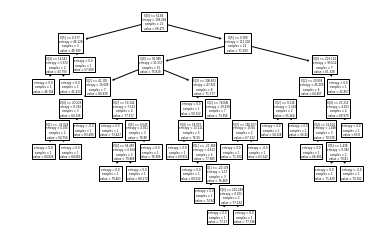

In [1701]:
# Shows the tree model
tree.plot_tree(clf)

In [33]:
# Creates dataframes of all the label locations, and one of all of their accuracies
df_finished_labeling = pd.read_csv('LabelingCanvas_FinishLabeling.csv')
df_all_labels = pd.read_csv('ml-label-correctness.csv')

In [147]:
# Sorts both dataframes in the same order so that accuracies line up with location
df_finished_labeling.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.drop(columns=('user_id'), inplace=True)

In [148]:
# creates a new dataframe containing all of the information
df_joined = df_finished_labeling.join(df_all_labels)
df_joined = df_joined[~pd.isna(df_joined['correct'])]
df_joined = df_joined[df_joined['lat'] > 46]
df_joined.to_csv('all_labels.csv', encoding='utf-8', index=False)

In [193]:
# Creates a csv file of the label data to be inputted into the cv model
df_cv = pd.DataFrame(cv_data, columns = cv_heading, index = cv_label_id)
df_cv.to_csv('Quality_Inferance_for_cv.csv', encoding='utf-8', index=False)

In [101]:
# Creates a dataframe of all of the seattle label's with their sv coordinates
df_sv_x_sv_y = pd.read_csv('sidewalk-seattle-label_point.csv')

In [190]:
# Creates a dataframe of all of the cv information fo each label
cv_data = []
cv_label_id = []
cv_heading = ['Timestamp', 'pano_id', 'sv_x', 'sv_y', 'label_type', 'label_id', 'user_id']
for index, current in enumerate(df_joined['label_id']):
    users_index = (df_sv_x_sv_y['label_id'] == current).idxmax()
    current_label = [df_joined['timestamp'].iloc[index], df_joined['gsv_panorama_id'].iloc[index], 
                     df_sv_x_sv_y['sv_image_x'].iloc[users_index], df_sv_x_sv_y['sv_image_y'].iloc[users_index],
                     df_joined['label_type'].iloc[index], current, df_joined['user_id'].iloc[index]]
    cv_label_id.append(current)
    cv_data.append(current_label)

In [241]:
df_summary = pd.read_csv('summary_user.csv')

In [268]:
# Checks the number of trues and false validations & the average confidence for both
df_temp = df_summary.groupby(['Correctness'])
for name,group in df_temp:
    print(name)
    print (group.agg(np.size))
    print(group.mean())

f
timestamp      10
pano_id        10
sv_x           10
sv_y           10
CVLabel        10
UserLabel      10
Confidence     10
Label_id       10
User_id        10
Correctness    10
dtype: int64
sv_x          7502.7
sv_y          -551.7
Confidence      56.4
Label_id      1427.2
dtype: float64
t
timestamp      649
pano_id        649
sv_x           649
sv_y           649
CVLabel        649
UserLabel      649
Confidence     649
Label_id       649
User_id        649
Correctness    649
dtype: int64
sv_x          6475.411402
sv_y          -587.191063
Confidence      54.473035
Label_id       584.926040
dtype: float64


In [266]:
# Adds the correctness of each user label of the cv analysis
for current_id in df_summary['Label_id']:
    label_index = (df_all_labels['label_id'] == current_id).idxmax()
    correctness = df_all_labels['correct'].iloc[label_index[0]]
    if current_id in df_summary['Label_id']:
        results_index = (df_summary['Label_id'] == current_id).idxmax() 
        df_summary['Correctness'].iloc[results_index] = correctness

In [276]:
# Checks how many labels that the cv and user has agreed on and whether they are correct or now
true = 0
false = 0
for current_id in df_summary['Label_id']:
    label_index = (df_summary['Label_id'] == current_id).idxmax()
    if df_summary['CVLabel'].iloc[label_index] == df_summary['UserLabel'].iloc[label_index]:
        if df_summary['Correctness'].iloc[label_index] == 'f':
            false += 1
        elif df_summary['Correctness'].iloc[label_index] == 't':
            true += 1
display(true)
display(false)

233

3

In [269]:
df_summary.to_csv('summary_user.csv', encoding='utf-8', index=False)

In [214]:
# Checks how many panos have had multiple users label
df_cv_grouped = df_summary.groupby(['pano_id'])
multiple_users = 0
for name, group in df_cv_grouped:
    if group['User_id'].nunique() != 1:
        multiple_users += 1
display(multiple_users)
display(len(df_cv_grouped))

51

2467

In [209]:
# Calculates the percentage that the CV model agrees with each user
df_cv_grouped = df_summary.groupby(['User_id'])
for name, group in df_cv_grouped:
        correct = 0
        total = 0
        for index, current in enumerate(group['CVLabel']):
            total += 1
            if current == group['UserLabel'].iloc[index]:
                correct += 1
        display(name)
        display(str(correct) + '/' + str(total) + '=' + str(float(correct) / float(total)))

'0e1ae564-6d72-4670-98e4-71369cc5ab26'

'75/257=0.2918287937743191'

'1353d168-ab49-4474-ae8a-213eb2dafab5'

'31/67=0.4626865671641791'

'2d9009b3-55d5-4aa8-a17a-a7c80afc4d51'

'149/413=0.36077481840193704'

'35872a6c-d171-40d9-8e66-9242b835ea71'

'6/19=0.3157894736842105'

'49723673-044d-4b47-855b-3bdebfe37073'

'217/802=0.27057356608478805'

'54c77d0f-fc8f-4497-84d3-5e336047b17e'

'18/43=0.4186046511627907'

'6809bd6e-605f-4861-bc49-32e52c88c675'

'3/11=0.2727272727272727'

'715af4d8-0f17-47c4-99c6-7ef92d94803a'

'60/174=0.3448275862068966'

'7b1596af-14d4-4f2b-9e4e-71b1884db836'

'4/14=0.2857142857142857'

'86d26e9d-010f-4802-88ba-680ae0a8e20d'

'56/172=0.32558139534883723'

'87833d72-b357-4e2c-81cd-23f58ff04c59'

'133/335=0.3970149253731343'

'8a471c0f-fa81-4c57-9b65-bd04a92c6a5e'

'13/52=0.25'

'939b6faa-0b57-4160-bcc2-d11fd2b69d9f'

'42/163=0.25766871165644173'

'9b595ba6-529b-4d37-93d7-dd189184e15a'

'54/163=0.3312883435582822'

'ac272eb8-3bb3-4260-9960-8e6c463f3867'

'12/25=0.48'

'af812204-1521-4c42-bf88-4baaaffe3f06'

'37/112=0.33035714285714285'

'bb64c416-b0bb-4a5b-b369-00f2a56fea3a'

'16/42=0.38095238095238093'

'bca24c1a-a6b1-4625-ab8e-9ff8693022d7'

'58/168=0.34523809523809523'

'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'

'63/191=0.3298429319371728'

'c7190807-b56e-40c5-b96e-49dc8368328c'

'3/11=0.2727272727272727'

'd3636d4c-2d16-410c-bf44-c066ecaf1c31'

'2/12=0.16666666666666666'

'dada416e-535f-4bb3-a213-172a8a94b581'

'32/100=0.32'

'dce5984b-25d9-48f9-b8b7-640202b3be3c'

'0/2=0.0'

'e4ff325c-309b-4ea6-8555-8f973e662362'

'109/283=0.38515901060070673'

'ec15a589-dd14-4513-a43e-8c06e55f4c71'

'29/88=0.32954545454545453'

'f13d2630-35fd-4a78-883d-d108be083425'

'29/81=0.35802469135802467'

'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5'

'15/42=0.35714285714285715'

'fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c'

'81/259=0.3127413127413127'

In [45]:
# Checks the number of labels in every pano
minimum_label_count = 7
df_joined_groups = df_joined.groupby(['gsv_panorama_id'])
for name,group in df_joined_groups:
    if len(group['gsv_panorama_id'].agg(np.size)) > minimum_label_count:
        print(name)
        display(len(group['gsv_panorama_id'].agg(np.size)))

0o5UD2lV47rsCz1NNl2_WQ


12

4Czt4q0BsHpIvLTRccKRuQ


12

55JjCbPXgFP2w7ubAXi7Vw


24

_ThcAfjL-9PVTI2IGWcIkg


9

aP5ZY6IHE3lziMBQQutnVg


10

oqP7byVfpym5eotQ9U4fdA


9

wuk--sZ3fJyMsMo4tJuybg


9

xknXWuoxVvX58NGN6sJ2vQ


9

In [1020]:
# Creates a csv of all of the labels of each users
for current_user in users['user_id']:
    current_correctness = df_joined[df_joined['user_id'] == current_user]
    current_correctness.to_csv('{0}_correctness.csv'.format(current_user), encoding='utf-8', index=False)

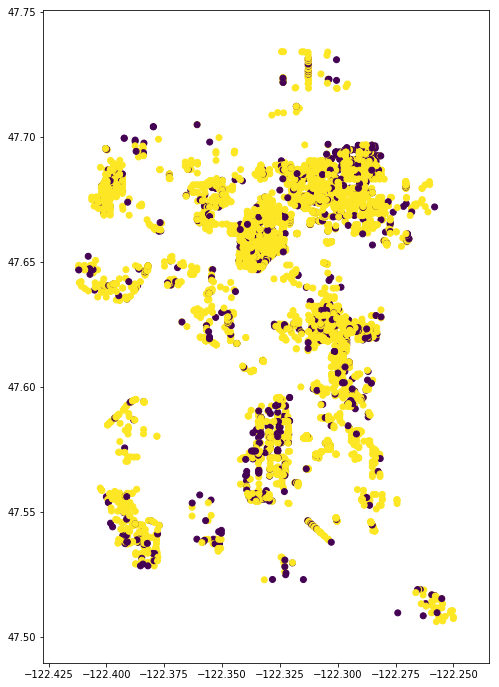

In [395]:
# Plots all validated labels
plt.figure(figsize=(8, 12))
plt.scatter(df_joined['lng'], df_joined['lat'], c = (df_joined['correct'] == 't'))

In [34]:
# Determines a user's accuracy for each of the label types
df_all_grouped = df_all_labels.groupby(['user_id','label_type'])
label_type_accuracy = {}
for current, group in df_all_grouped:
    users_index = (users['user_id'] == current[0]).idxmax()
    correct = sum(group['correct'] == 't')
    false = sum(group['correct'] =='f')
    if correct + false != 0:
        label_type_accuracy[current] = (correct / (correct + false))

In [84]:
# Plots a given feature against the user's accuracy on the 4 label types
def label_accuracy_per_type(feature_name):
    f, axs = plt.subplots(2,2,figsize=(12,8))
    plt.subplot(221)
    label_type_accuracy_graph('CurbRamp', feature_name)
    plt.subplot(222)
    label_type_accuracy_graph('NoCurbRamp', feature_name)
    plt.subplot(223)
    label_type_accuracy_graph('Obstacle', feature_name)
    plt.subplot(224)
    label_type_accuracy_graph('SurfaceProblem', feature_name)

In [85]:
# Plots features versus accuracies of different label types
def label_type_accuracy_graph(label_type, feature_name):
    user_information = {}
    for index, current_user in enumerate(users['user_id']):
        feature_info = df_all.at[current_user, feature_name]
        user_information[current_user] = feature_info , label_type_accuracy[current_user,label_type] 
    label_scatter_plot(feature_name, user_information, label_type)

In [86]:
# Plots the feature versus the label type accuracy
def label_scatter_plot(info_type, user_information, label_type):
    for entry in user_information.keys():
        users_index = (users['user_id'] == entry).idxmax()
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        user_accuracy = users.at[users_index,'accuracy']
        if entry in overall_bad_users:
            current_color = 'red'
        elif user_accuracy < 65:
            current_color = 'black'
        else:
            current_color = 'blue'
        plt.plot(info, accuracy, '.', color = current_color)
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [89]:
label_accuracy_per_type('Average Pitch')

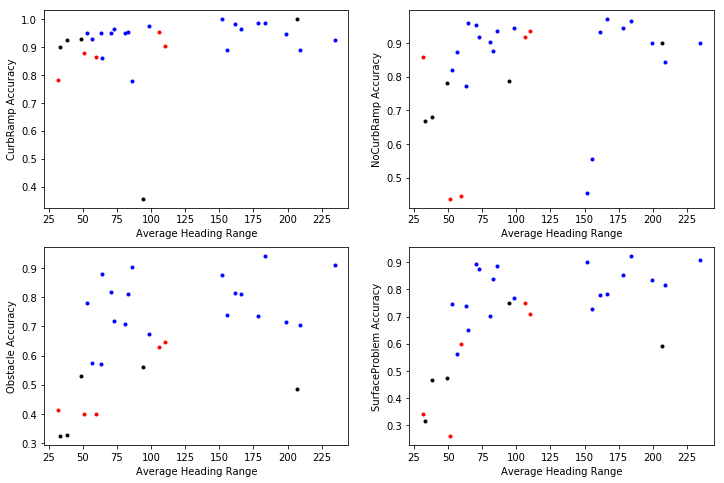

In [1521]:
label_accuracy_per_type('Average Heading Range')

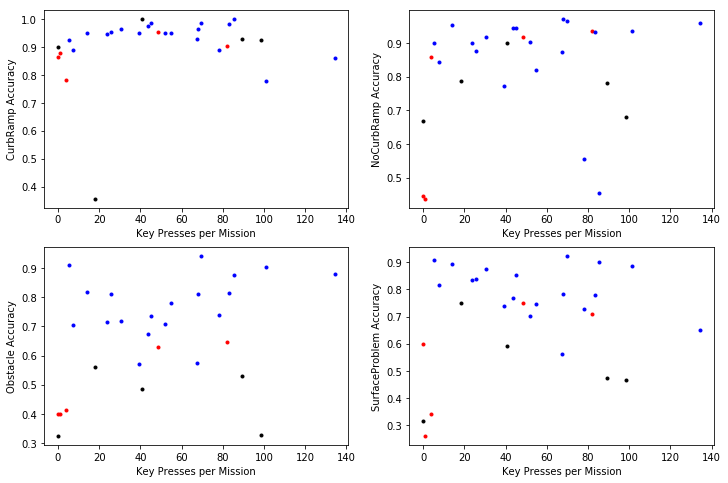

In [1522]:
label_accuracy_per_type('Key Presses per Mission')

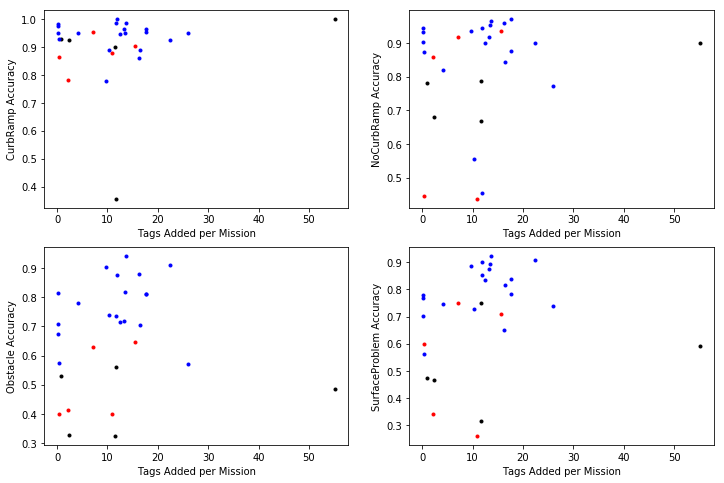

In [1523]:
label_accuracy_per_type('Tags Added per Mission')

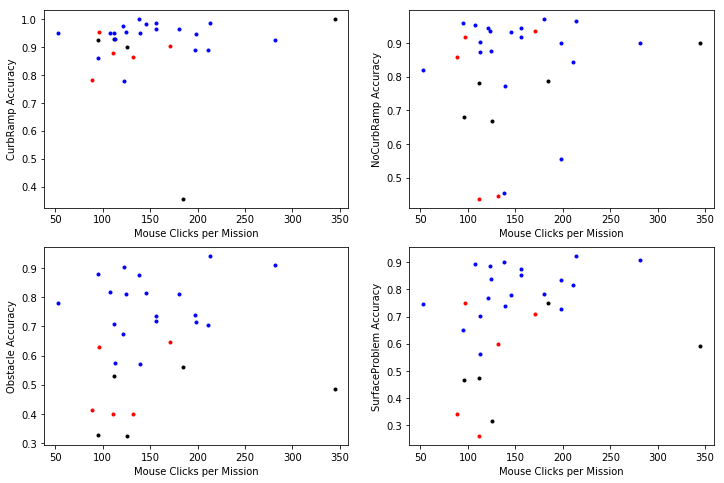

In [1524]:
label_accuracy_per_type('Mouse Clicks per Mission')

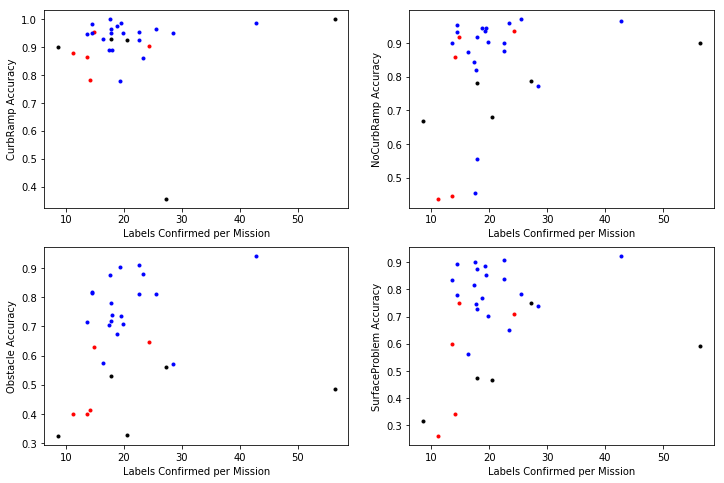

In [1525]:
label_accuracy_per_type('Labels Confirmed per Mission')

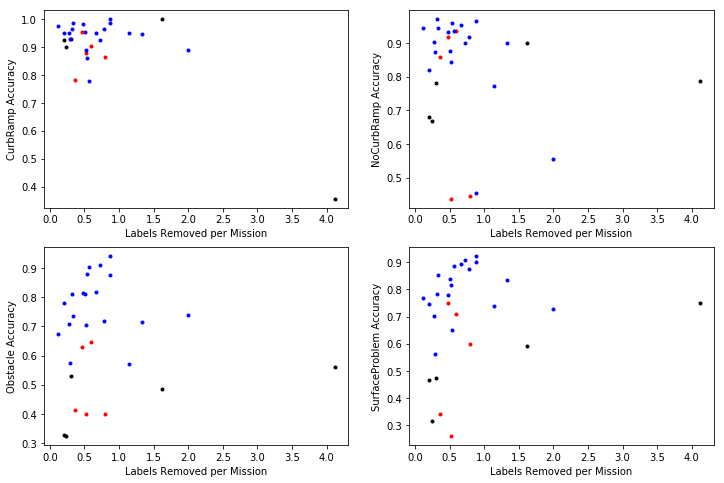

In [1526]:
label_accuracy_per_type('Labels Removed per Mission')

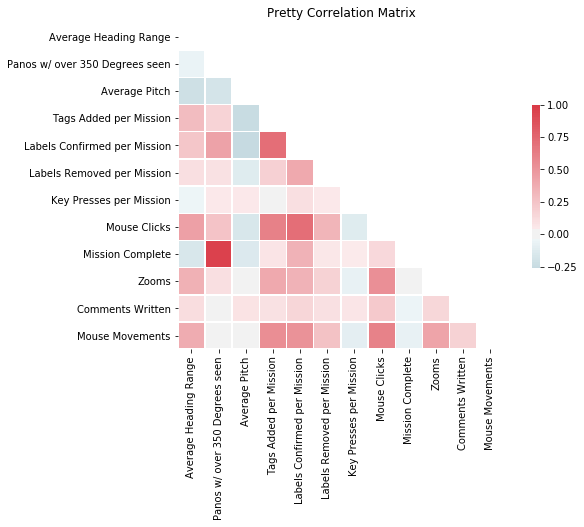

In [205]:
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})

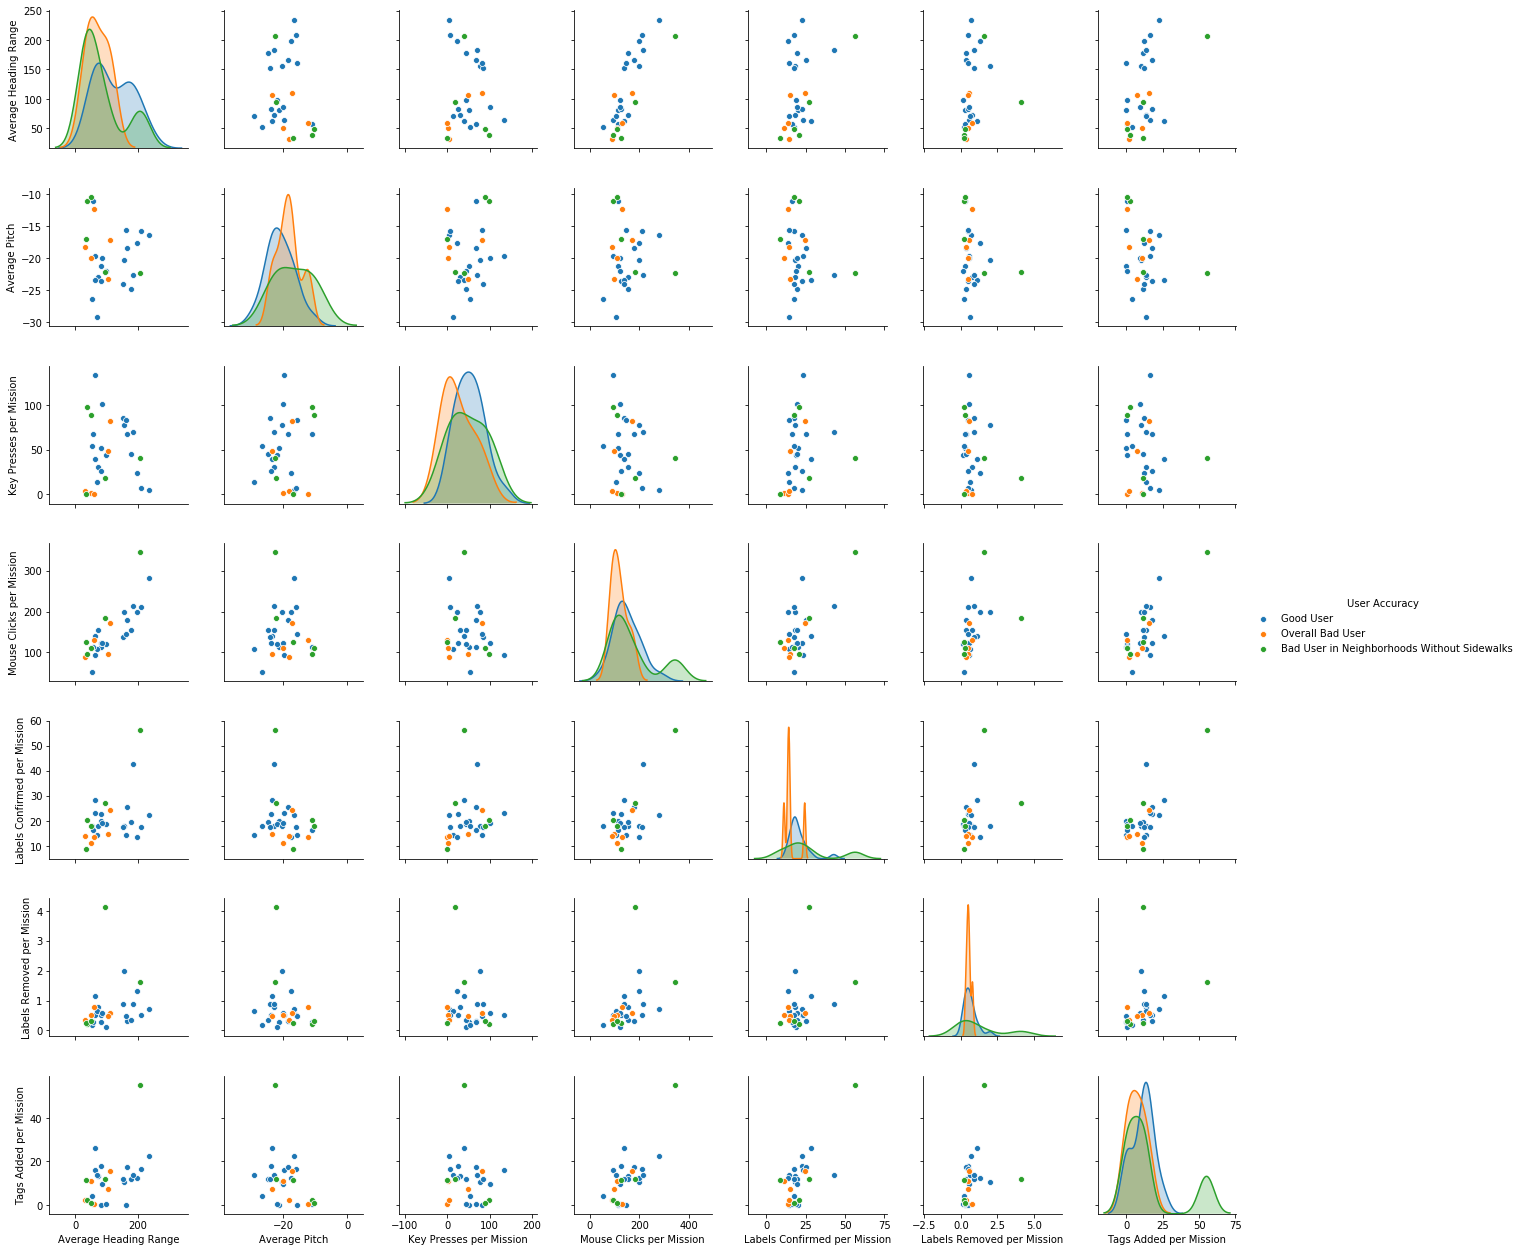

In [1573]:
# Compares how different features are related to each other
sns_plot = sns.pairplot(df_all, hue='User Accuracy')

In [18]:
df_all_new = pd.read_csv('users_one_mission.csv')
display(df_all_new)

,user_id,total_labels,labels_validated,correct_labels,false_labels,accuracy,missions_completed
0,0e1ae564-6d72-4670-98e4-71369cc5ab26,7194,1690,1321,369,78.165680,364
1,bca24c1a-a6b1-4625-ab8e-9ff8693022d7,5240,737,536,201,72.727273,184
2,49723673-044d-4b47-855b-3bdebfe37073,4950,1365,1204,161,88.205128,219
3,ec15a589-dd14-4513-a43e-8c06e55f4c71,4904,886,564,322,63.656885,275
4,f13d2630-35fd-4a78-883d-d108be083425,4881,1217,906,311,74.445357,297
5,715af4d8-0f17-47c4-99c6-7ef92d94803a,4629,592,495,97,83.614865,198
6,af812204-1521-4c42-bf88-4baaaffe3f06,4574,639,529,110,82.785602,257
7,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,4337,1063,951,112,89.463782,243
8,bf16418a-4c99-4fd6-99c6-7e8b40fbe17b,2540,482,400,82,82.987552,132
9,7b1596af-14d4-4f2b-9e4e-71b1884db836,1935,541,437,104,80.776340,103


In [19]:
# Calculates the missions completed, labels placed, and accuracy of each user of a certain
# threshold
all_info = {}
for index, current_id in enumerate(df_all_new['user_id']):
    missions_completed = df_all_new['missions_completed'][index]
    total_labels = df_all_new['total_labels'][index]
    accuracy = df_all_new['accuracy'][index]
    if total_labels > 26:
        all_info[current_id] = float(total_labels) / float(missions_completed), missions_completed, accuracy

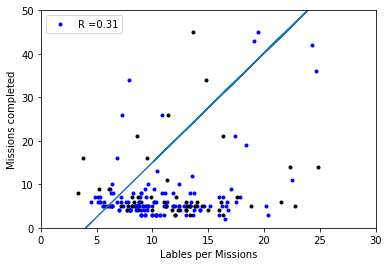

In [30]:
# Creates a graph comparing labels per mission to missions completed
user_information = all_info
plt.xlabel('Lables per Missions')
plt.ylabel('Missions completed')
plt.xlim(0, 30)
plt.ylim(0, 50)
for entry in user_information.keys():
    user_info = user_information.get(entry)
    info = user_info[0]
    missions = user_info[1]
    accuracy = user_info[2]
#     if entry in overall_bad_users:
# #         if accuracy > 65:
#         plt.plot(info, missions, '.', color = 'red')
    if accuracy < 70:
            plt.plot(info, missions, '.', color = 'black')
    else:
        plt.plot(info, missions, '.', color = 'blue')
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

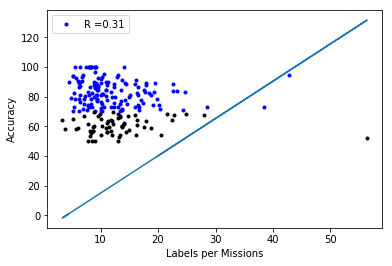

In [21]:
# Creates a graph comparing labels per mission to accuracy
plt.ylabel('Accuracy')
plt.xlabel('Labels per Missions')
for entry in user_information.keys():
    user_info = user_information.get(entry)
    info = user_info[0]
    missions = user_info[1]
    accuracy = user_info[2]
#     if entry in overall_bad_users:
# #         if accuracy > 65:
#         plt.plot(info, missions, '.', color = 'red')
    if accuracy < 70:
            plt.plot(info, accuracy, '.', color = 'black')
    else:
        plt.plot(info, accuracy, '.', color = 'blue')
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [216]:
hs_interaction = pd.read_csv('ml-interactions-jaaonraces.csv')
hs_labels = pd.read_csv('ml-label-correctness-jaaonraces.csv')

In [43]:
display(hs_labels)

,user_id,label_id,label_type,temporary_label_id,audit_task_id,correct
0,d2b04e27-13ce-4aff-a06a-7c7147c96696,74674,CurbRamp,1,15828,NaN
1,d2b04e27-13ce-4aff-a06a-7c7147c96696,74675,CurbRamp,1,15829,NaN
2,d2b04e27-13ce-4aff-a06a-7c7147c96696,74676,CurbRamp,2,15829,NaN
3,d2b04e27-13ce-4aff-a06a-7c7147c96696,74677,NoCurbRamp,3,15829,NaN
4,d2b04e27-13ce-4aff-a06a-7c7147c96696,74678,CurbRamp,4,15829,NaN
5,d2b04e27-13ce-4aff-a06a-7c7147c96696,74679,CurbRamp,5,15829,NaN
6,d2b04e27-13ce-4aff-a06a-7c7147c96696,74680,NoSidewalk,6,15829,NaN
7,d2b04e27-13ce-4aff-a06a-7c7147c96696,74681,CurbRamp,7,15829,NaN
8,d2b04e27-13ce-4aff-a06a-7c7147c96696,74682,NoSidewalk,8,15831,NaN
9,d2b04e27-13ce-4aff-a06a-7c7147c96696,74683,NoSidewalk,9,15831,NaN


In [217]:
total = len(hs_labels)
accuracy = 0
correct = sum(hs_labels['correct'] == 't')
false = sum(hs_labels['correct'] == 'f')
validated = correct + false
if validated != 0:
    accuracy = float(correct) / float(validated) * 100
missions_completed = user_missions[hs_labels['user_id'][1]]
hs_info = hs_labels['user_id'][1], total, validated, correct, false,  accuracy, missions_completed

In [225]:
display(hs_info)
display(user_missions['d2b04e27-13ce-4aff-a06a-7c7147c96696'])

('d2b04e27-13ce-4aff-a06a-7c7147c96696', 87, 19, 16, 3, 84.21052631578947, 8)

8

In [224]:
hs_features = df_all.iloc[283]
display(hs_features)

Average Heading Range               57.496428
Panos w/ over 350 Degrees seen       1.000000
Average Pitch                      -20.097967
Tags Added per Mission               4.333333
Labels Confirmed per Mission         4.333333
Labels Removed per Mission           0.000000
Key Presses per Mission            203.666667
Mouse Clicks                        18.333333
Mission Complete                     1.000000
Zooms                                0.333333
Comments Written                     0.000000
Mouse Movements                   2505.666667
Name: d5e1a7c0-b593-4246-b32f-b82136c4accc, dtype: float64

In [244]:
# Reads all of the dc data by users and indexes it
dc_anon = pd.read_csv('dc-anon-interactions.csv')
dc_registered = pd.read_csv('dc-registered-interactions.csv')
dc_turk = pd.read_csv('dc-turker-interactions.csv')
dc_anon.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
dc_registered.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
dc_turk.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)

In [245]:
# combines all of the dc data into one dataframe
dc_all = pd.concat((dc_registered, dc_anon, dc_turk))

In [30]:
dc_all.to_csv('dc-all-interactions.csv', encoding='utf-8', index=False)

In [12]:
dc_all = pd.read_csv('dc-all-interactions.csv')

In [13]:
display(dc_all)

,timestamp,user_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note
0,2016-06-14 03:59:47.309+00,26e51ea3-440a-4730-ae04-1457aeeb686b,TaskStart,bdmGHJkiSgmO7_80SnbzXw,38.940487,-77.067680,270.010925,-7.4250,1.0,NaN
1,2016-06-14 04:00:03.936+00,26e51ea3-440a-4730-ae04-1457aeeb686b,TaskSubmit,9L2PGnwQtQCzubbjTbD8HA,38.892090,-76.929291,188.635941,-4.0500,1.0,NaN
2,2016-06-14 04:00:01.806+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_MouseDown,fKqHhOxplEuI6LpUnDVx5A,38.892143,-76.929276,236.260941,-6.8625,1.0,"x:487,y:301"
3,2016-06-14 04:00:03.716+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_MouseDown,9L2PGnwQtQCzubbjTbD8HA,38.892143,-76.929276,188.635941,-4.0500,1.0,"x:339,y:341"
4,2016-06-14 04:00:02.758+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_MouseDown,fKqHhOxplEuI6LpUnDVx5A,38.892143,-76.929276,193.698441,-5.5500,1.0,"x:469,y:282"
5,2016-06-14 04:00:03.893+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_MouseUp,9L2PGnwQtQCzubbjTbD8HA,38.892143,-76.929276,188.635941,-4.0500,1.0,"x:339,y:341"
6,2016-06-14 03:59:47.152+00,26e51ea3-440a-4730-ae04-1457aeeb686b,RefreshTracker,bdmGHJkiSgmO7_80SnbzXw,38.940487,-77.067680,270.010925,-7.4250,1.0,NaN
7,2016-06-14 04:00:03.092+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_MouseUp,fKqHhOxplEuI6LpUnDVx5A,38.892143,-76.929276,188.635941,-4.0500,1.0,"x:496,y:290"
8,2016-06-14 04:00:03.893+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_DoubleClick,9L2PGnwQtQCzubbjTbD8HA,38.892143,-76.929276,188.635941,-4.0500,1.0,NaN
9,2016-06-14 04:00:00.499+00,26e51ea3-440a-4730-ae04-1457aeeb686b,ViewControl_MouseDown,fKqHhOxplEuI6LpUnDVx5A,38.892143,-76.929276,270.010925,-7.4250,1.0,"x:523,y:306"


In [10]:
dc_users = pd.read_csv('cv-accuracy.csv')

In [11]:
display(dc_users)

,condition.id,worker1,true.pos,false.pos,true.neg,false.neg,precision,recall,specificity,f.measure,raw.accuracy,worker.type
0,70,01232fef-5a19-4435-8be6-c0da3b38cabd,9,8,48,3,0.529412,0.750000,0.857143,0.620690,0.838235,reg
1,70,A3PPRVK6XK6GP5,9,3,53,3,0.750000,0.750000,0.946429,0.750000,0.911765,turk1
2,72,9501513f-3822-4921-861e-8f1440dee102,13,12,16,7,0.520000,0.650000,0.571429,0.577778,0.604167,reg
3,72,A1TNQU9L5L62PL,16,14,14,4,0.533333,0.800000,0.500000,0.640000,0.625000,turk1
4,73,32f21407-253f-46ea-a01b-55bcf4ac2113,18,8,26,4,0.692308,0.818182,0.764706,0.750000,0.785714,reg
5,73,A35QYDS8MRV1EX,17,6,28,5,0.739130,0.772727,0.823529,0.755556,0.803571,turk1
6,74,A20BMZQJS92QY2,17,5,3,3,0.772727,0.850000,0.375000,0.809524,0.714286,turk1
7,74,b65c0864-7c3a-4ba7-953b-50743a2634f6,10,5,3,10,0.666667,0.500000,0.375000,0.571429,0.464286,reg
8,75,0bfed786-ce24-43f9-9c58-084ae82ad175,10,5,23,2,0.666667,0.833333,0.821429,0.740741,0.825000,reg
9,75,A3AUDX0SE41K23,12,11,17,0,0.521739,1.000000,0.607143,0.685714,0.725000,turk1


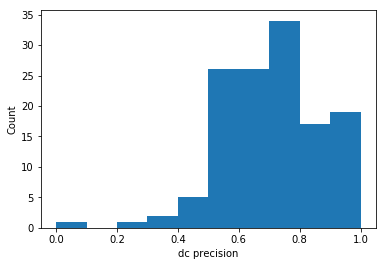

In [271]:
histogram('dc precision', dc_users['precision'])

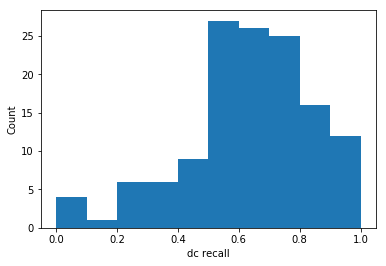

In [268]:
histogram('dc recall', dc_users['recall'])

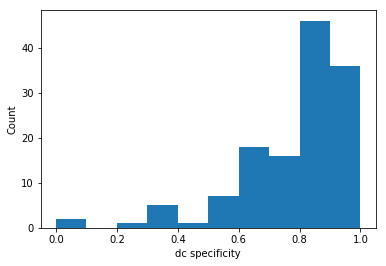

In [269]:
histogram('dc specificity', dc_users['specificity'])

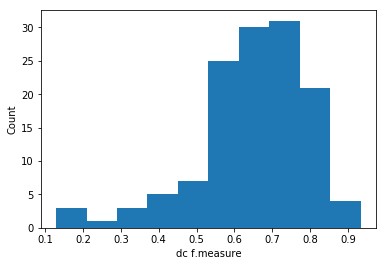

In [270]:
histogram('dc f.measure', dc_users['f.measure'])

In [140]:
#  Count of all the dc users by type
dc_worker_types = dc_users.groupby('worker.type')
for name, group in dc_worker_types:
    print(name)
    print(len(group))

anon
16
reg
50
turk1
66
